# Analyze Filter

This notebook is used to visualize the efficacy of the filter when applied to a dataset.

### Datasets
#### Different Datasets for Filters

The first few filters generalized very poorly from their training datasets to the competition datasets. The training datasets need to be created manually. This is because on the competition datasets, there is only a binary label. But in order to reproduce the gravitational-wave(GW) and ultimately in the future increase the signal to noise ratio(SNR) of the time series, the shape of the gravitational wave needs to be known:

* in the case of the model being tasked with reproducing the GW, the difference between the model's prediction and the ground truth needs to be calculated

* in the case of noise suppression, the SNRs of the sample before and after the model is applied to the time series need to be calculated and compared.

For this reason, the datasets used to train the filters on were made using the signal generation code from [this paper](https://arxiv.org/pdf/1904.08693.pdf) was altered to be able to use Virgo data as well as data from the two LIGO detectors and used to create multiple datasets.


#### Initial Results

Initially, the results of using the filter trained on the synthetic datasets on the kaggle datasets were very poor. This lead to some ideas:

1. The pre-processing is different in both datasets: In the Kaggle dataset, only 2s of data is available. In the pre-processing, the noise is whitened (filtered, so that all frequency bins have the same amplitude) and highpassed (frequencies below a certain threshold are cut out). Both of these processes corrupt data at the beginning and end of the time series. For this reason the normal procedure, which was also used in the creation of the synthetic dataset is to process a larger time frame around the important time (typically 10s) and cut off about 2s from both ends to eliminate corrupted data. This was not possible on the competition dataset, since only 2s were available for each sample. 

To alleviate this issue, some datasets have been and are currently being created using no pre-processing at all of length 2s. They are later run through the same pre-processing pipeline as the competition dataset. Unnecessary pre-processing steps are eliminated.

2. When infering on synthetic datasets created in the first batch using detection models trained on only the kaggle dataset, the AUC was 0.99 for datasets with a simulated distance of 100 Mpc between event and detector and 0.88 at 300 Mpc. This meant two things:
    * The reported SNR by the data creation pipeline is wrong, because the SNR was set to the same in all datasets, which means that the 100 Mpc ones should be just as hard for the models to predict on as the 300 Mpc ones. This could be caused by the changes I made to the code while including the Virgo detector.
    * The datasets created are much too simple. If a model trained on a dataset with a completely different pre-processing pipeline can perform this well on another dataset, the dataset is far less complicated than the one it was trained on.
    
To deal with this problem, the SNR calculation of the data creation pipeline was reverted to the one used on just the LIGO detectors and the SNR parameters were set much lower than would be expected from the kaggle dataset in the second batch of datasets. Additionally the simulated distance was increased.

In [1]:
import tensorflow as tf
import os
from glob import glob
import matplotlib.pyplot as plt
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
from IPython.core.display import display, HTML
import numpy as np
display(HTML("<style>.container { width:90% !important; }</style>"))
tf.keras.mixed_precision.set_global_policy("float32")

## Load the model

In [2]:
model = tf.keras.models.load_model("model5.h5")

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2080 Ti, compute capability 7.5


In [3]:
from tensorflow.keras import backend as K

The following cells are used to transform a model from the mixed precision scope into a float32 scope for training on a tpu. They will be moved in the future

This function is used to load a dataset from a list of `tfrec` files.

In [10]:
def load_dataset(files, window=True, synthetic=False):
    dataset = tf.data.TFRecordDataset(files, num_parallel_reads = None)
    
    def _parse_function(example_proto):
        keys_to_feature = {}
        keys_to_feature["TimeSeries"] = tf.io.FixedLenFeature([4096,3], tf.float32)
        keys_to_feature["Target"] = tf.io.FixedLenFeature([], tf.int64)
        
        if synthetic:
            keys_to_feature["GroundTruths"] = tf.io.FixedLenFeature([4096,3], tf.float32)
        
        parsed_features = tf.io.parse_single_example(example_proto, keys_to_feature)
        if synthetic:
            return parsed_features["TimeSeries"], parsed_features["Target"],parsed_features["GroundTruths"]
        else:
            return parsed_features["TimeSeries"], parsed_features["Target"]
            
    
    dataset = dataset.map(_parse_function, num_parallel_calls=-1)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(buffer_size=10000, reshuffle_each_iteration=True)
    dataset = dataset.batch(64)
#     dataset = dataset.cache()
    dataset = dataset.prefetch(-1)
    return dataset

In [38]:
ds = load_dataset(glob("../input/like-synthetic-short-whitened-highpassed-tfrec/*")[-1], synthetic=False)
ds_synth = load_dataset(glob("../input/synthetic-tfrec/*")[-1], synthetic=True)

show the example vector

In [39]:
for x in ds:
    vec = x
    break

In [41]:
for x1 in ds_synth:
    vec_synth = x1
    break

This cell is used to plot results on datasets with ground truth (i.e. the gravitational-wave without noise, in the case when the objective of the model is to reproduce the wave)

In [44]:
vec_synth[0]

<tf.Tensor: shape=(64, 4096, 3), dtype=float32, numpy=
array([[[-2.29221085e-04, -5.31011377e-04, -9.20498918e-04],
        [ 9.02147905e-04,  7.49274157e-04,  1.14136981e-03],
        [-1.02818827e-03, -2.00582226e-03, -7.81847339e-04],
        ...,
        [-5.07826393e-04, -7.90603575e-04,  3.74463270e-04],
        [-1.20592152e-03,  9.17665777e-04, -3.75792413e-04],
        [ 5.81071246e-04, -4.78060538e-04,  2.37277942e-04]],

       [[ 2.51039659e-04, -6.06757414e-04,  2.09853861e-05],
        [ 1.12112990e-04,  1.17480592e-03, -3.06784961e-04],
        [ 7.69154358e-05, -4.36195231e-04,  4.87240555e-04],
        ...,
        [ 4.01339348e-04,  1.33480784e-03,  7.46924488e-04],
        [-3.93857859e-04, -7.17451214e-04, -5.52154728e-04],
        [ 3.88067274e-05,  1.18363940e-03,  1.38889824e-03]],

       [[-2.23592928e-04, -3.55604971e-05, -1.33846799e-04],
        [ 5.01448289e-04,  5.87359027e-05, -1.67936756e-04],
        [ 4.06092498e-04, -8.81930056e-04, -3.88233602e-05],


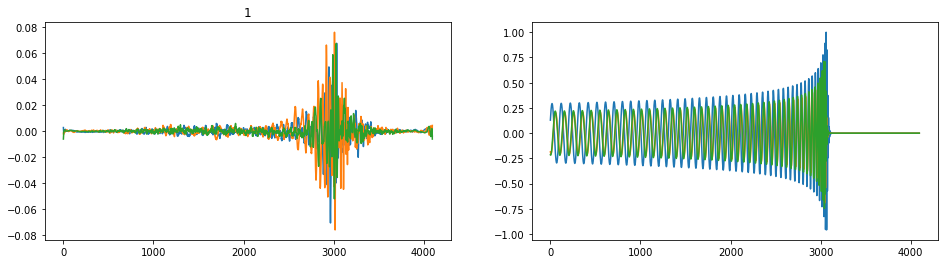

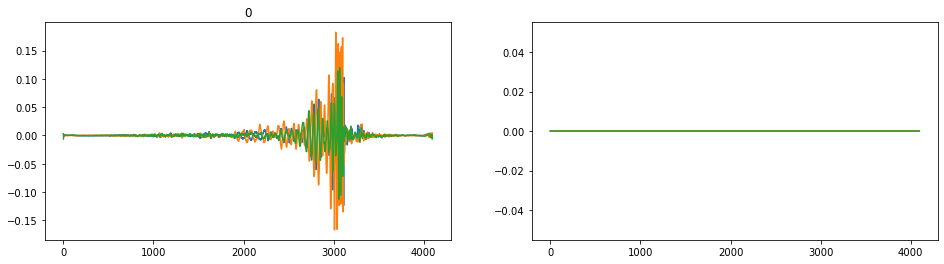

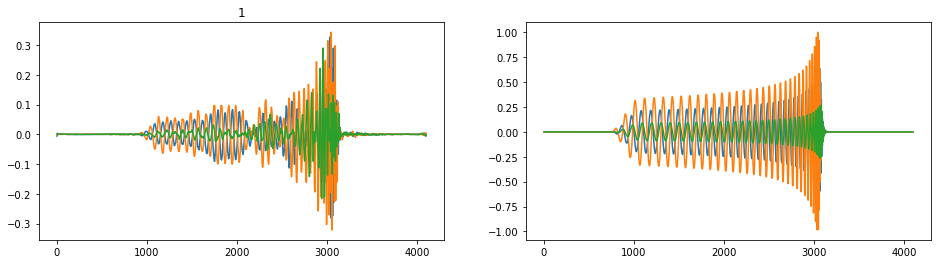

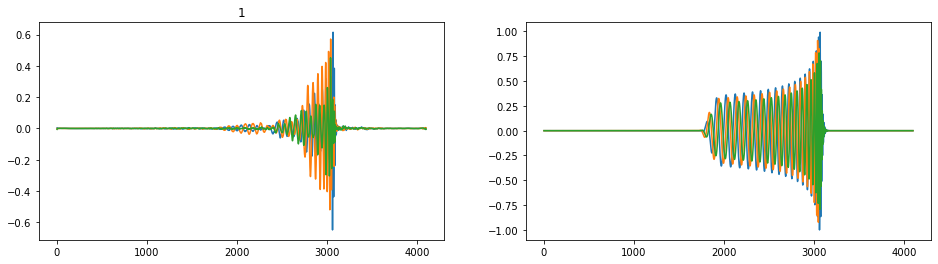

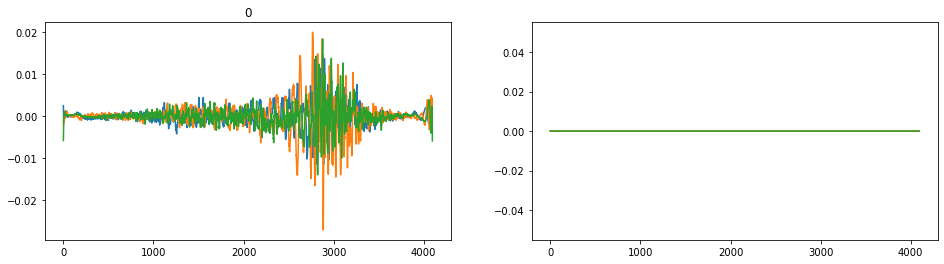

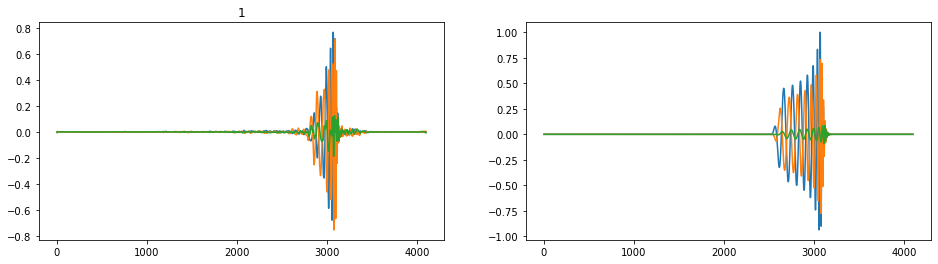

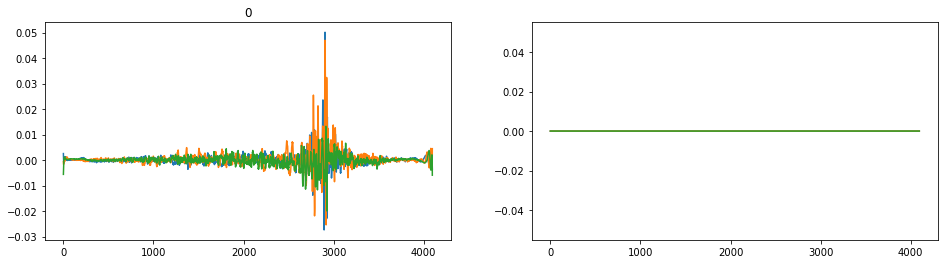

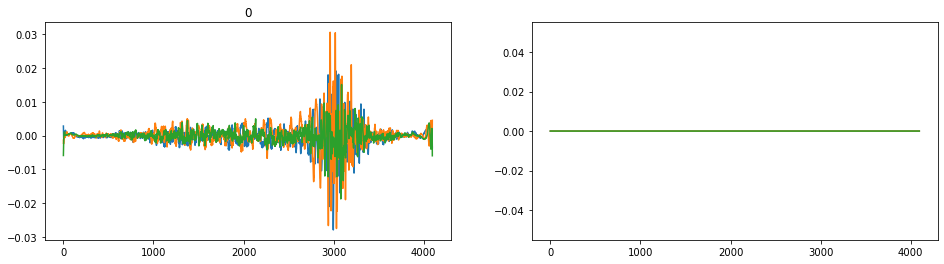

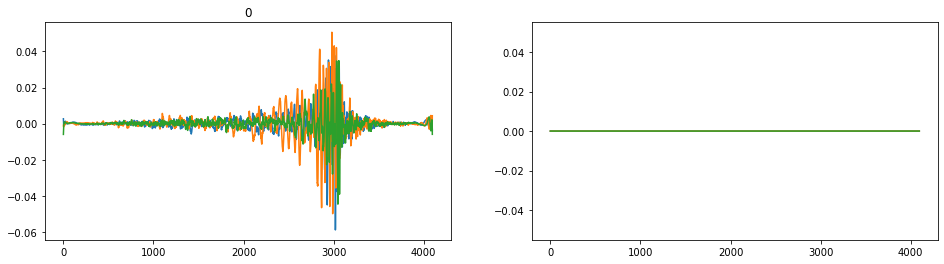

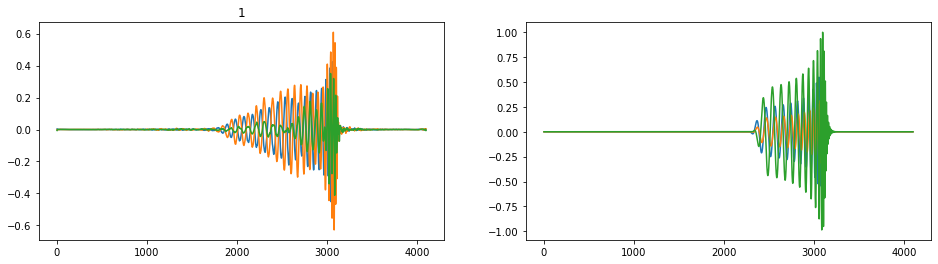

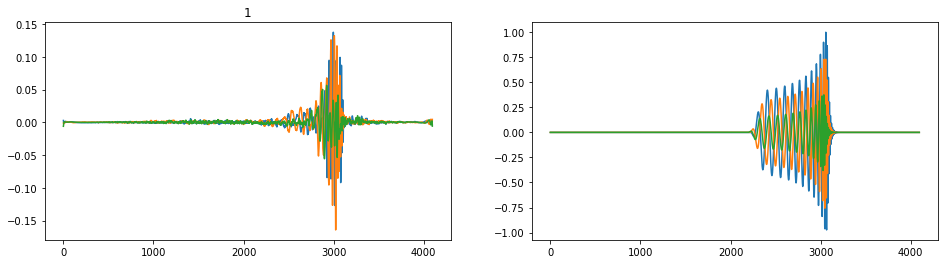

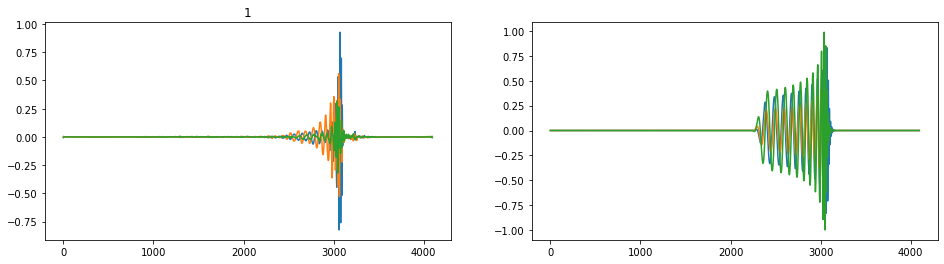

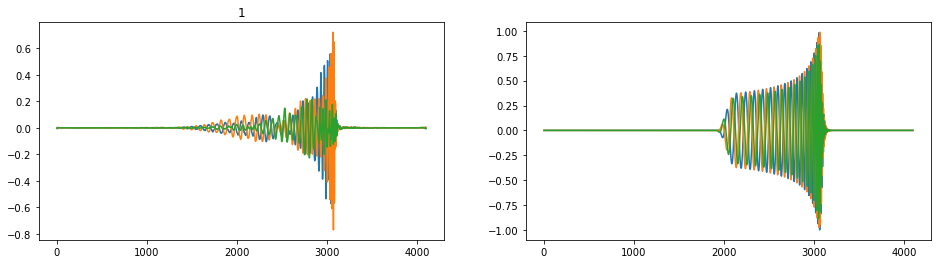

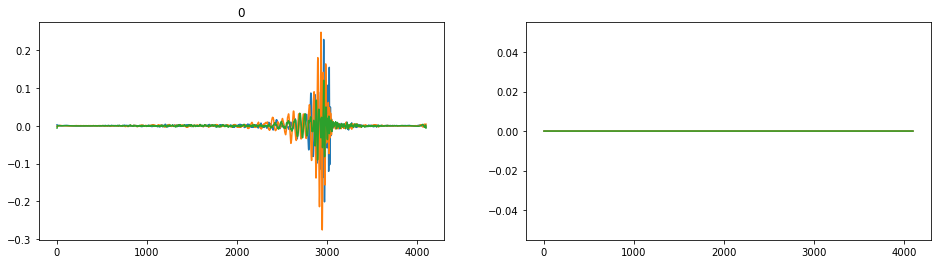

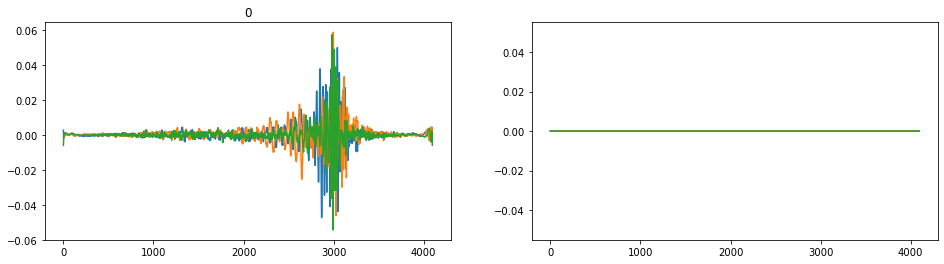

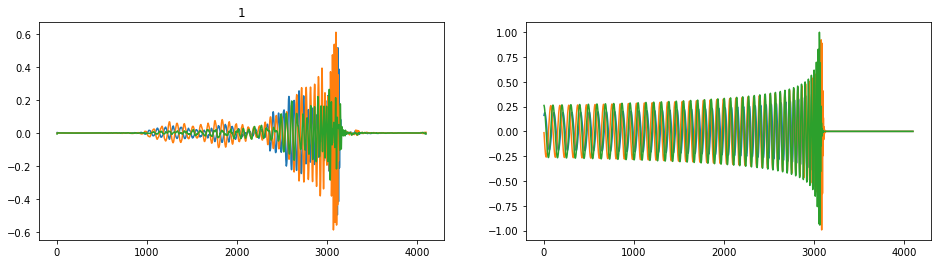

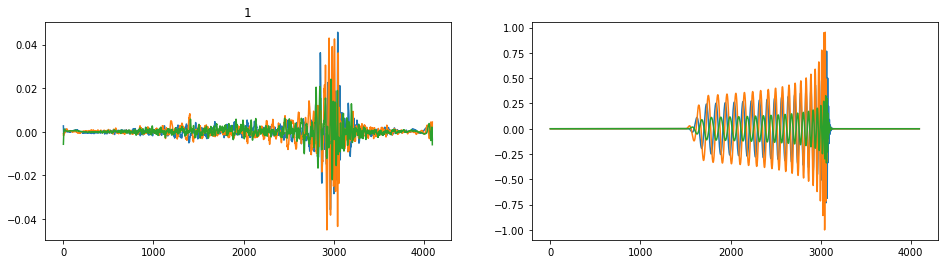

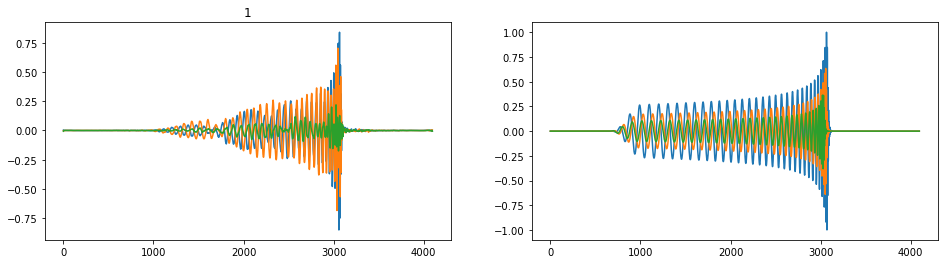

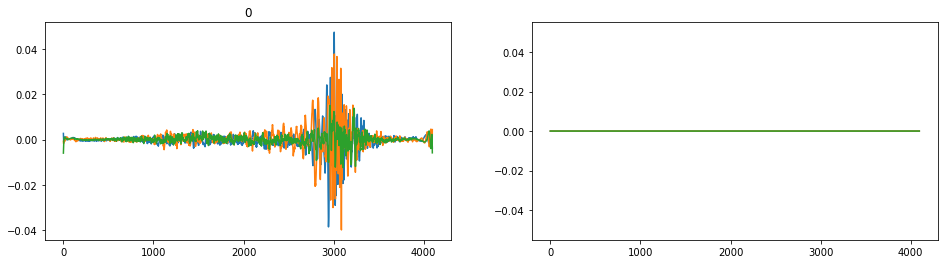

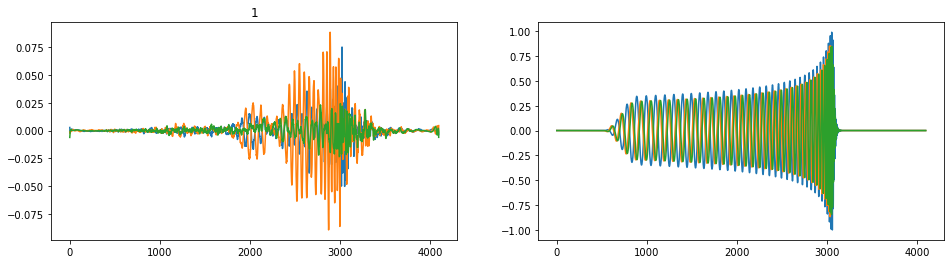

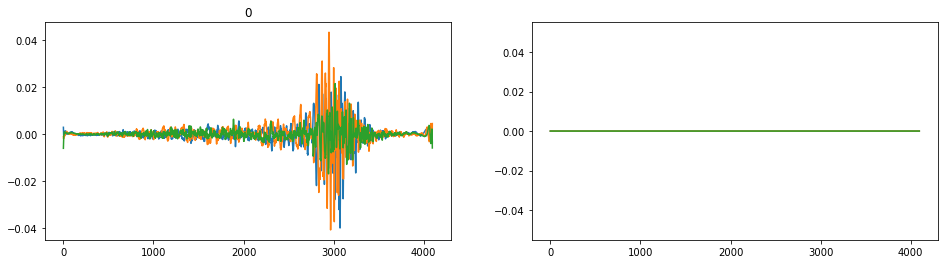

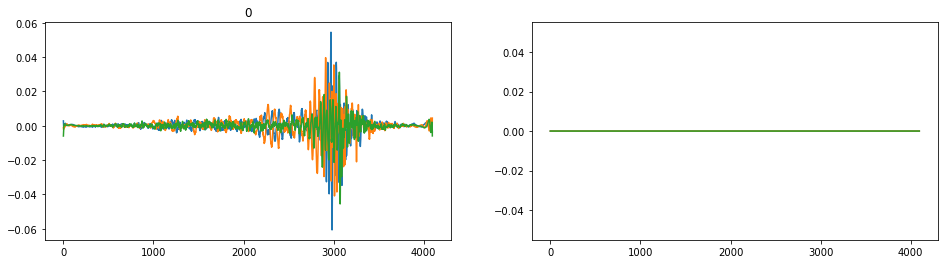

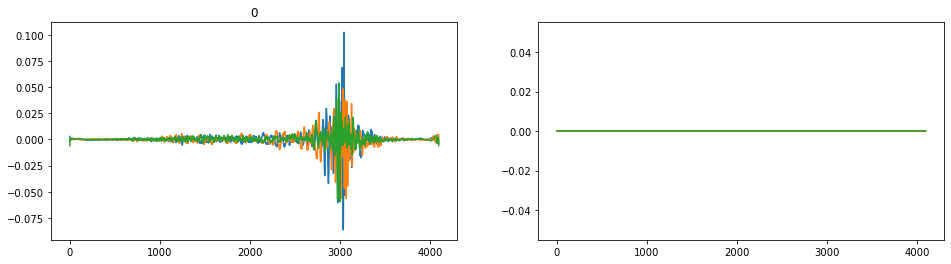

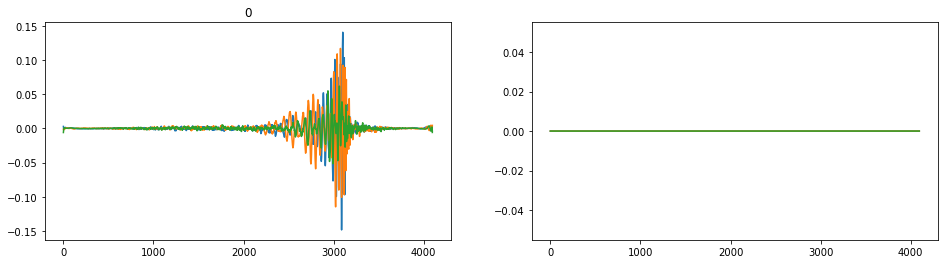

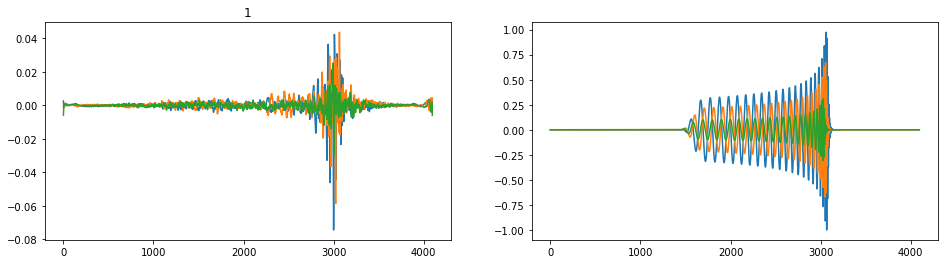

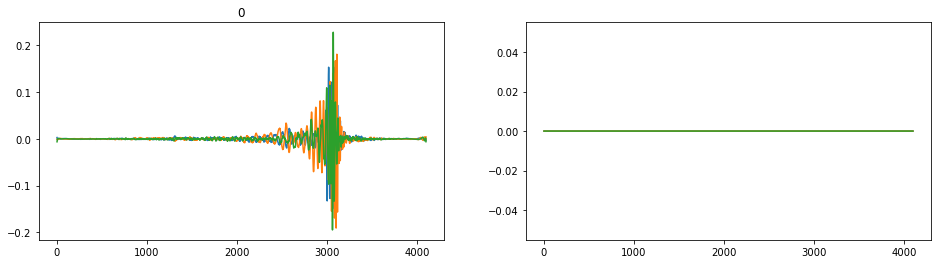

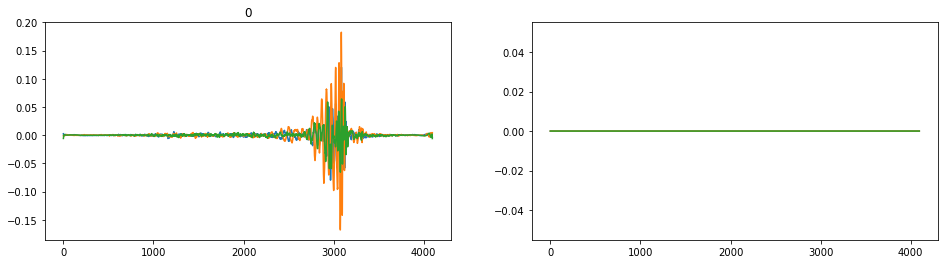

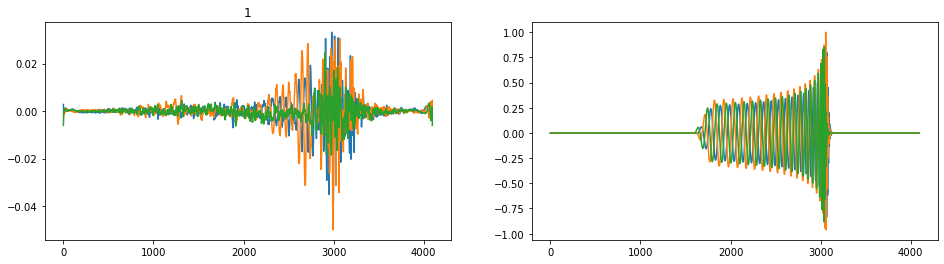

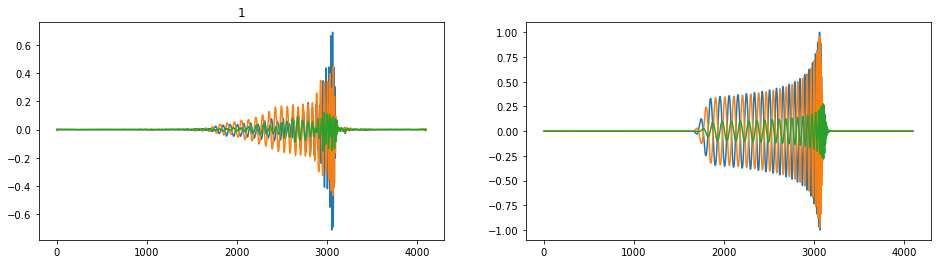

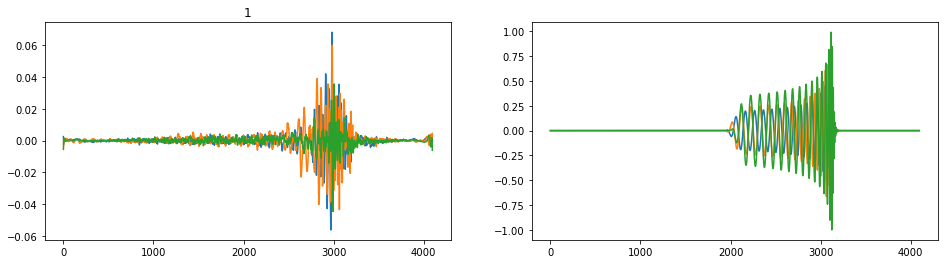

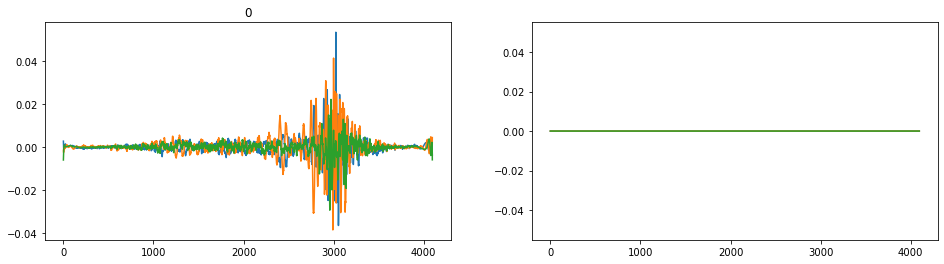

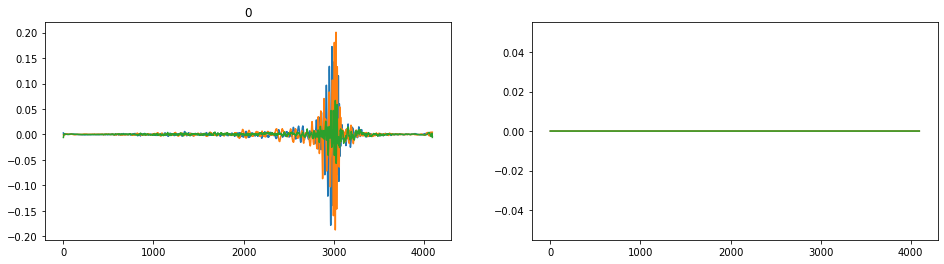

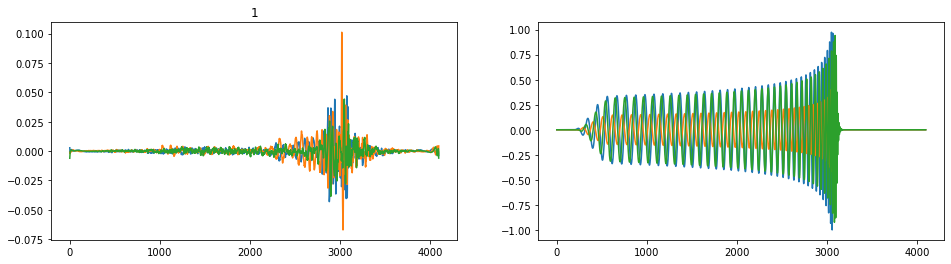

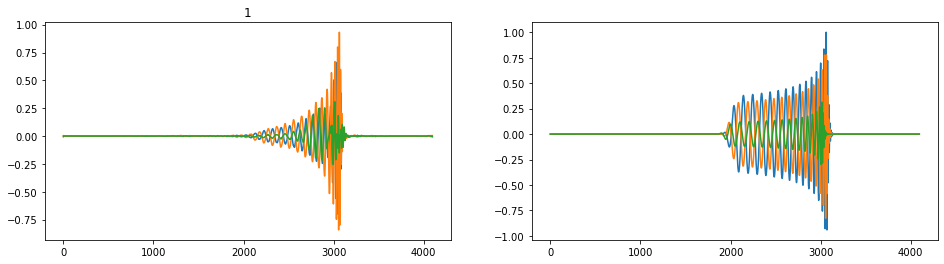

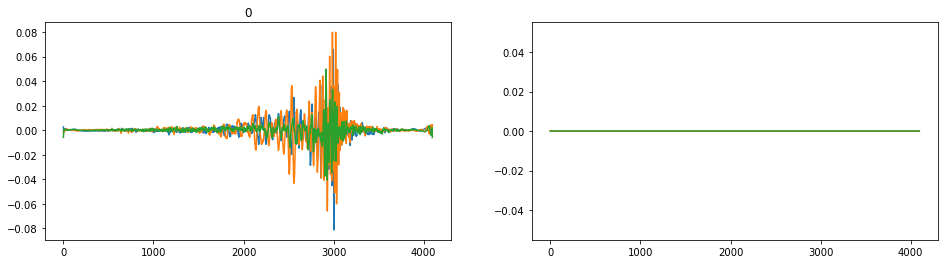

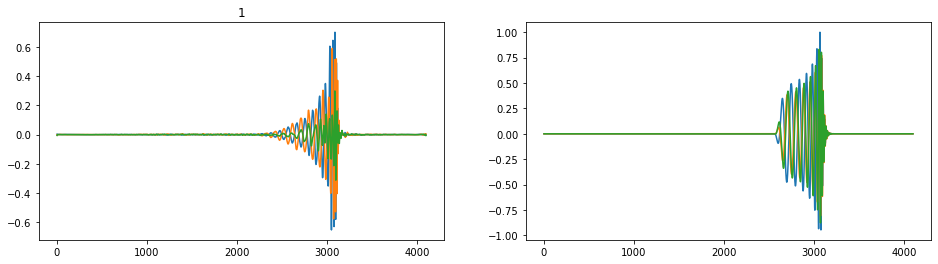

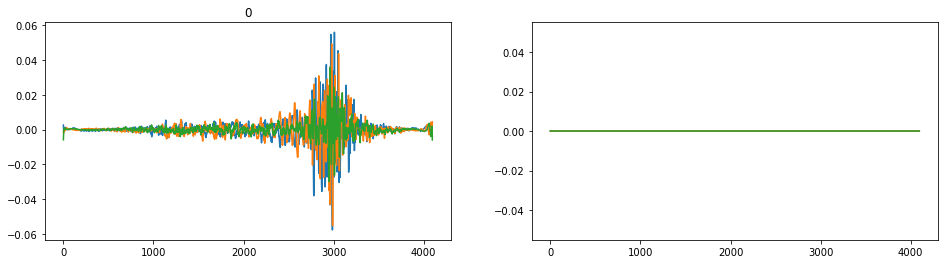

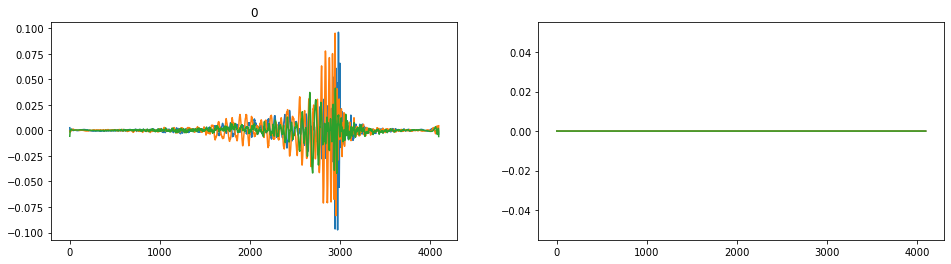

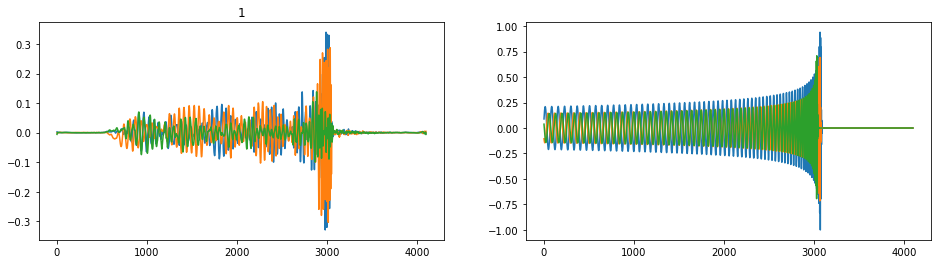

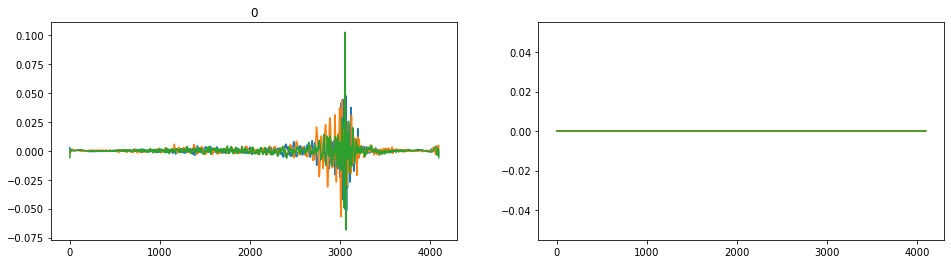

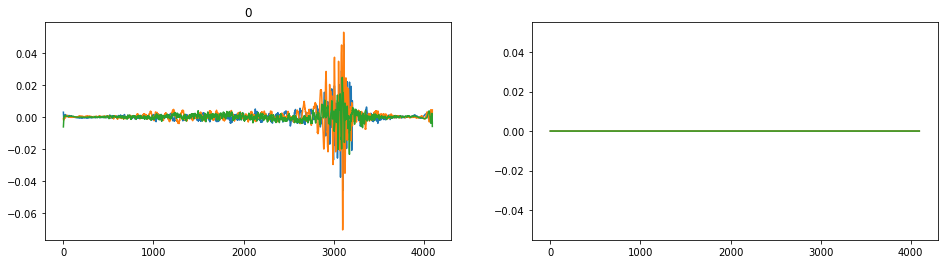

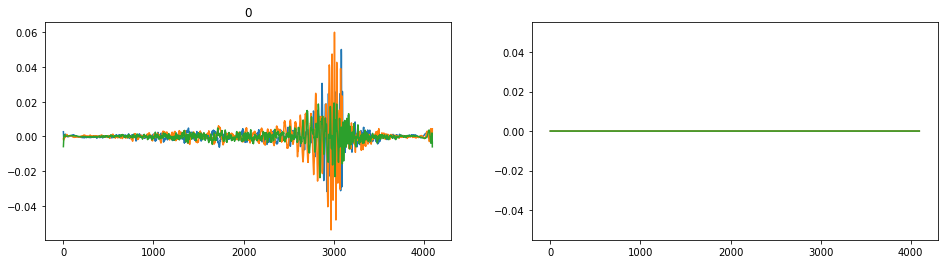

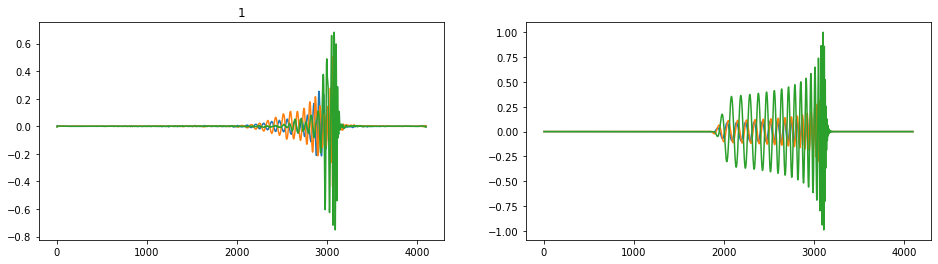

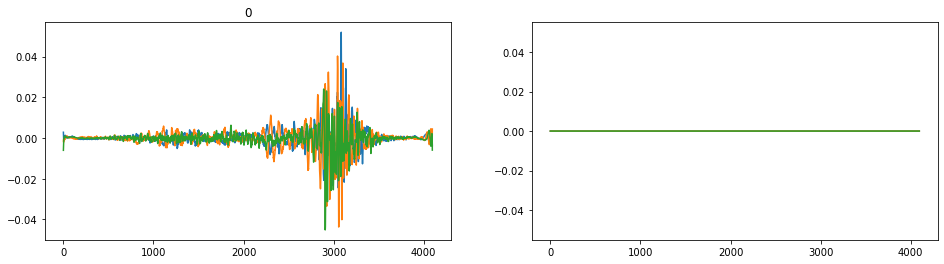

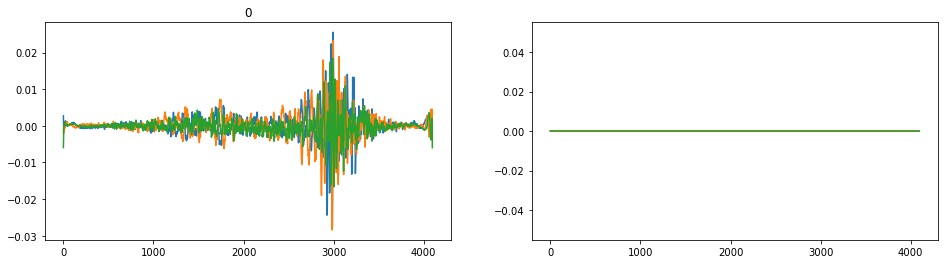

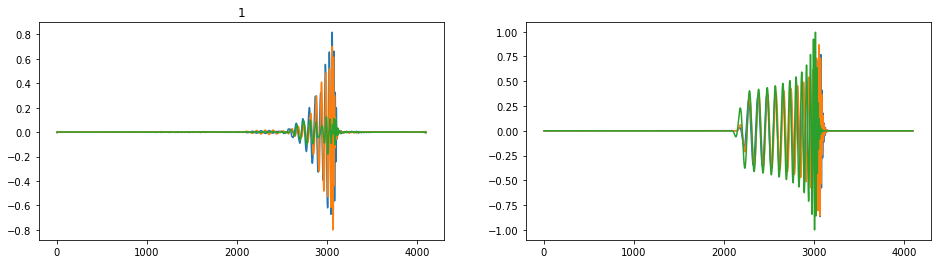

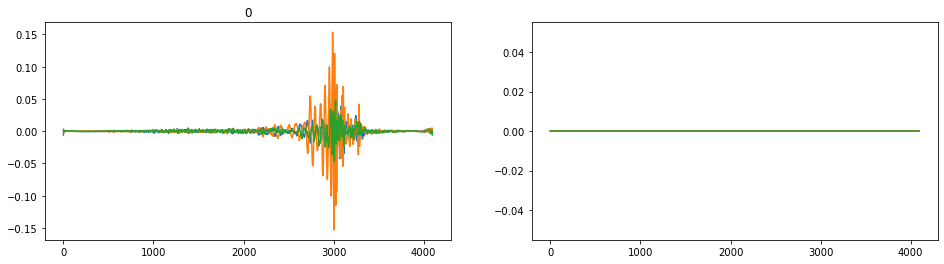

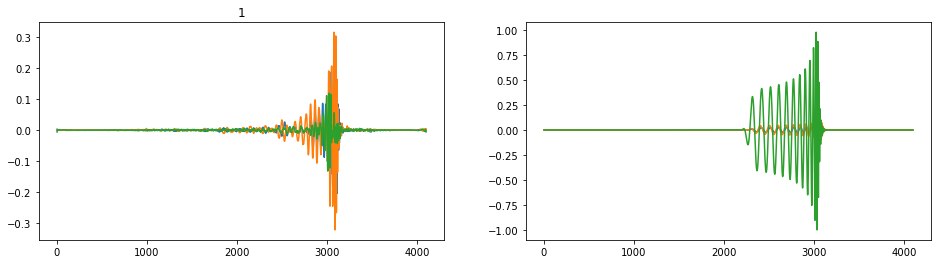

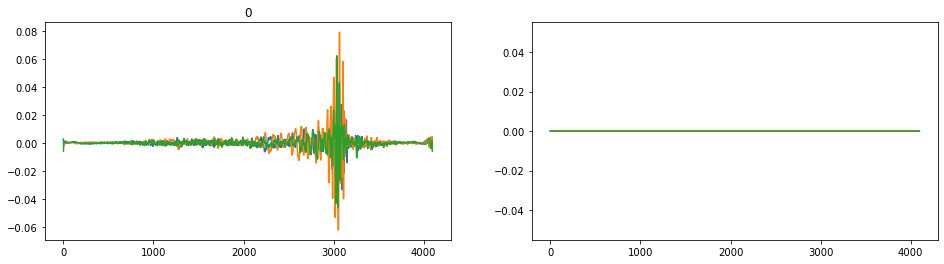

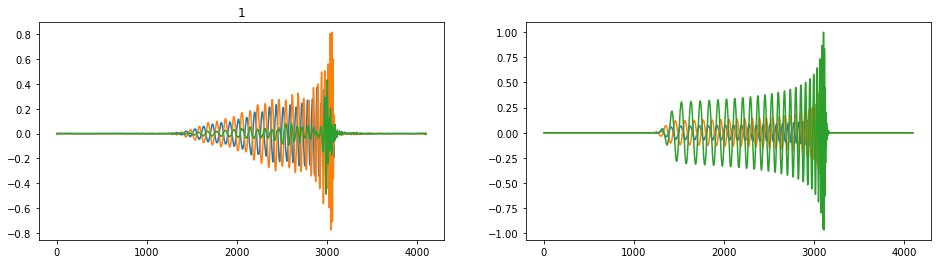

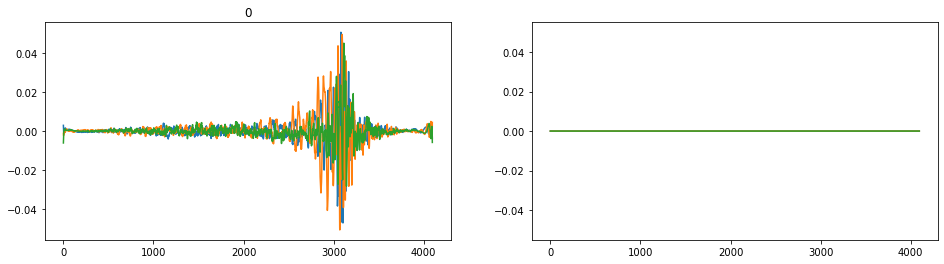

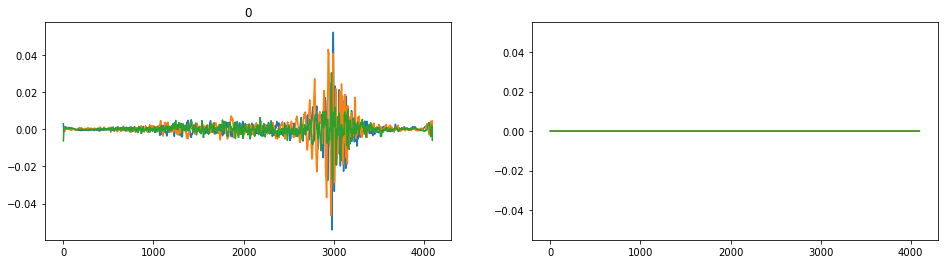

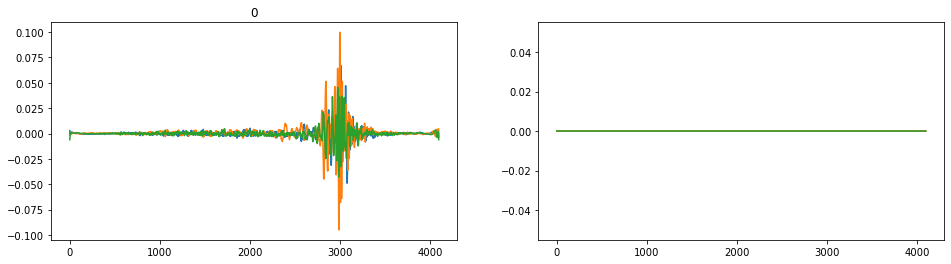

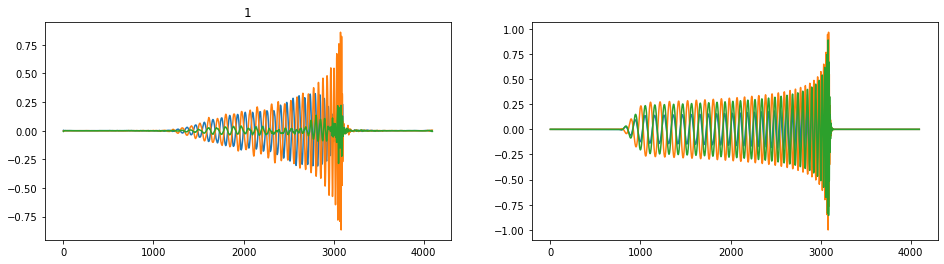

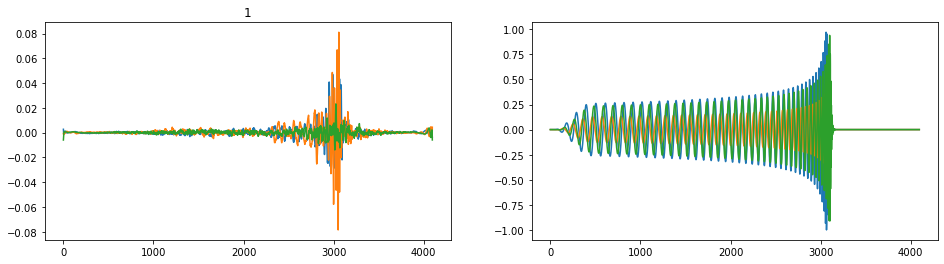

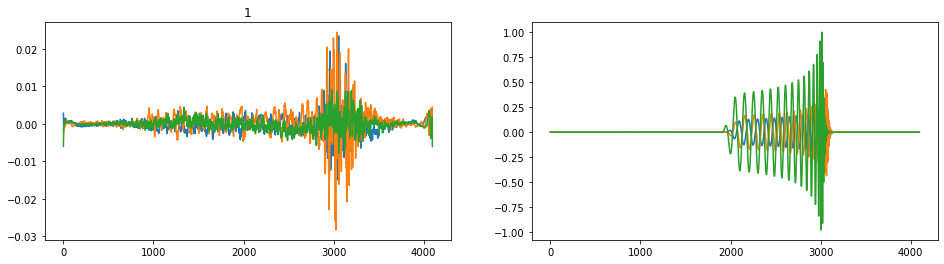

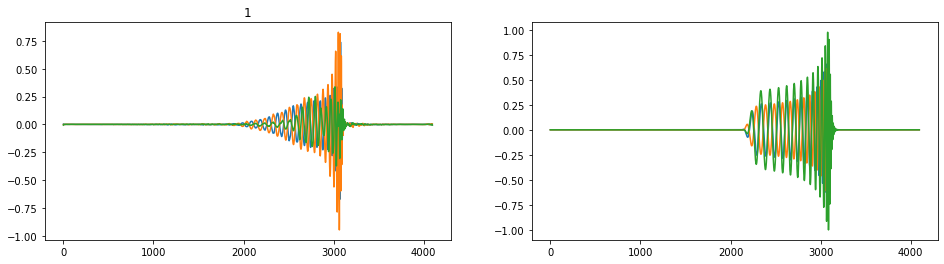

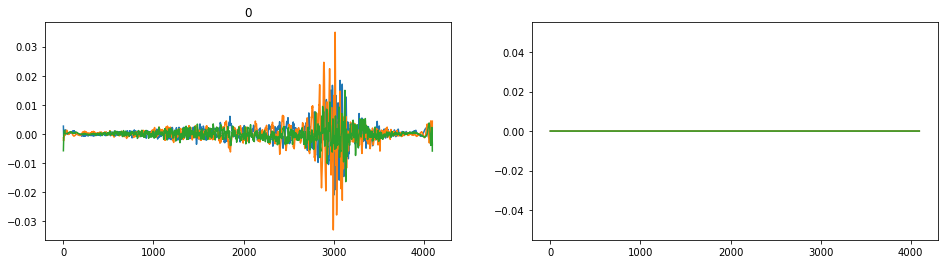

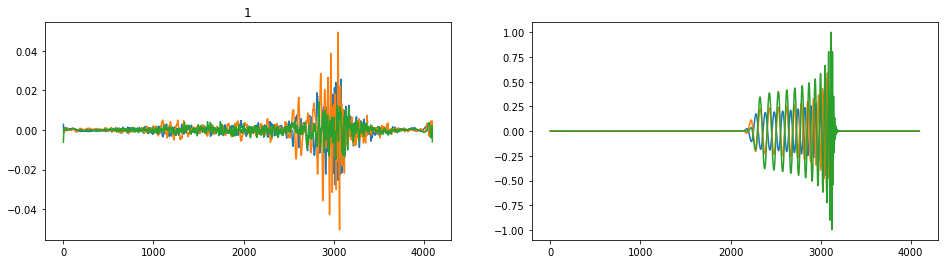

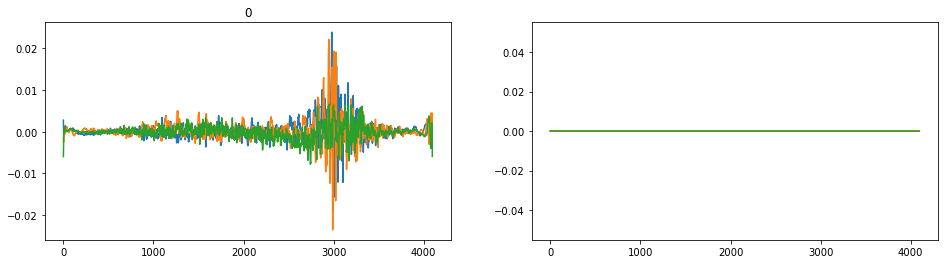

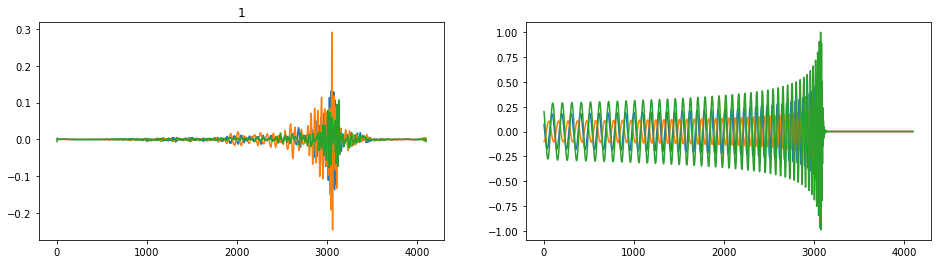

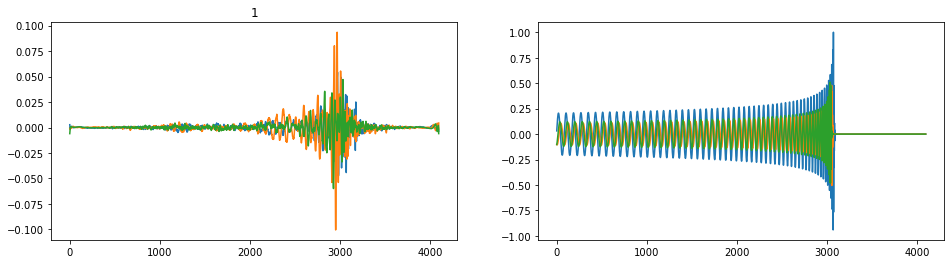

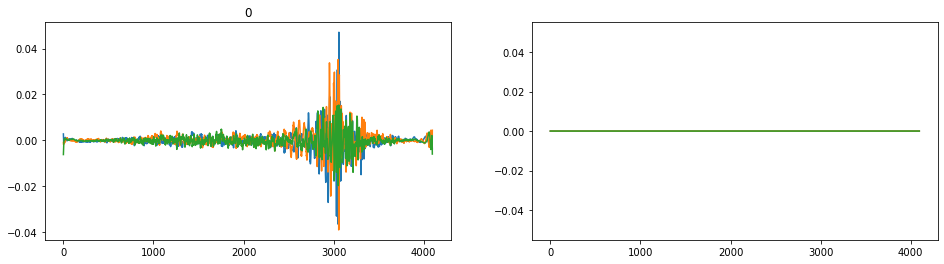

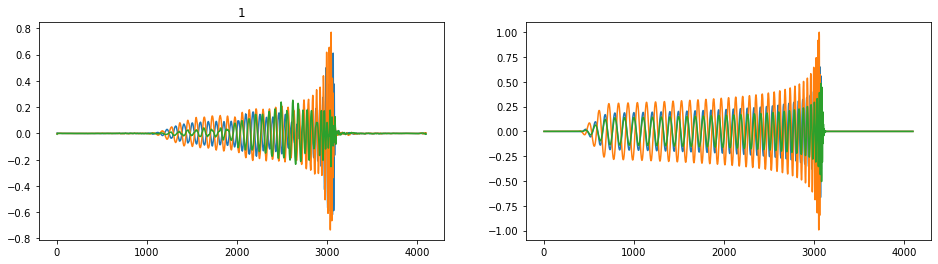

In [46]:
# predictions=model.predict(vec[0])
predictions = model.predict(vec_synth[0])

for i in range(64):
    plt.figure(figsize=(16,4))
    plt.subplot(1,2,1) 
    plt.plot(predictions[i])
    plt.title(vec_synth[1][i].numpy())
    plt.subplot(1,2,2)
    plt.plot(vec_synth[2][i])

    plt.show()

this cell is used to plot the 

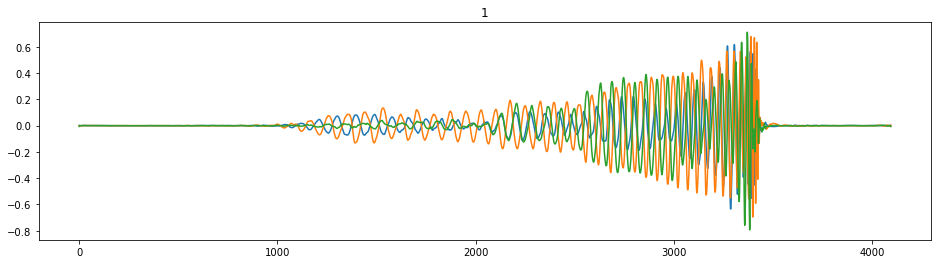

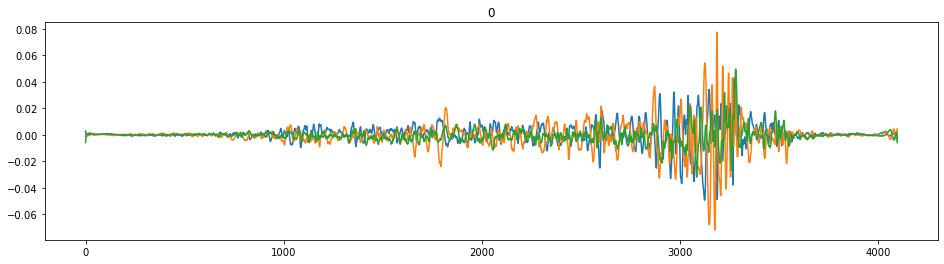

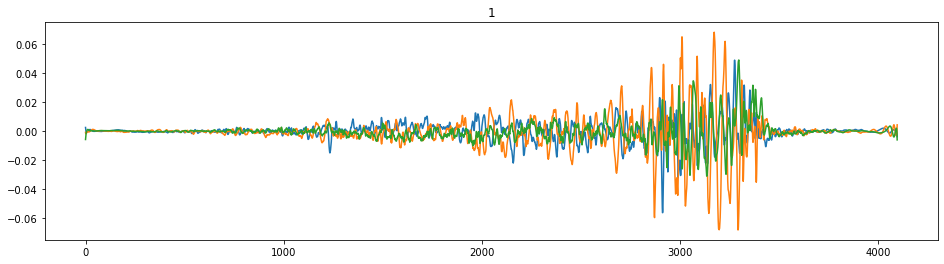

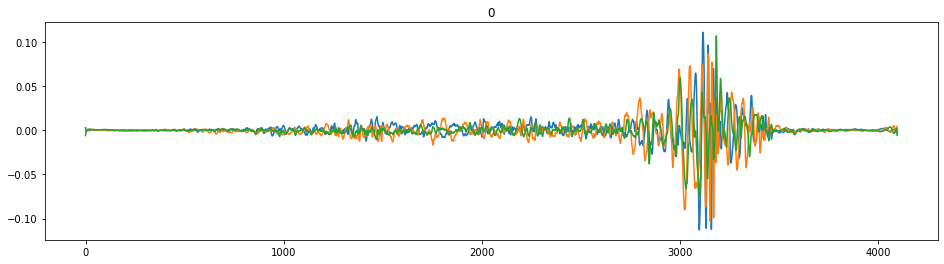

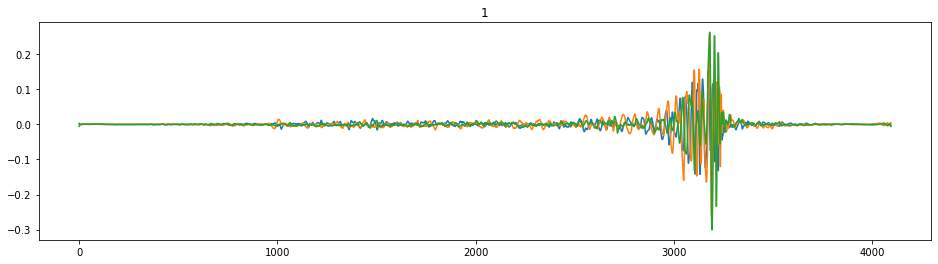

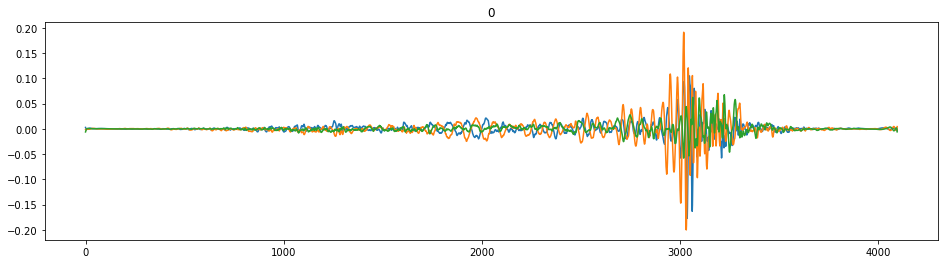

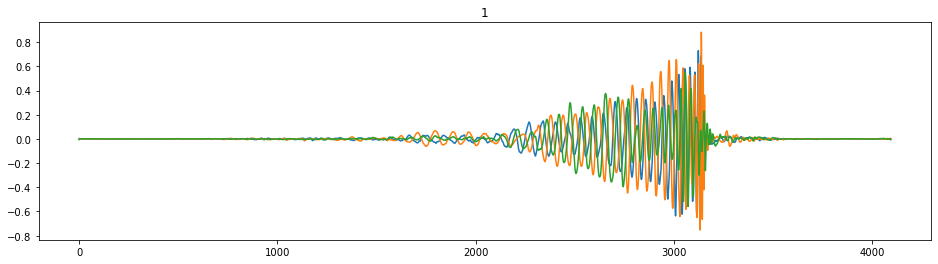

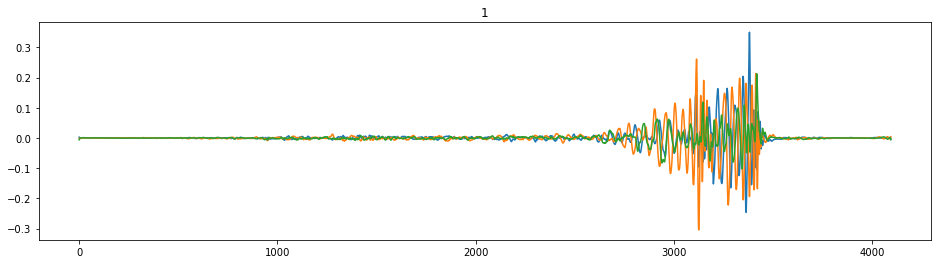

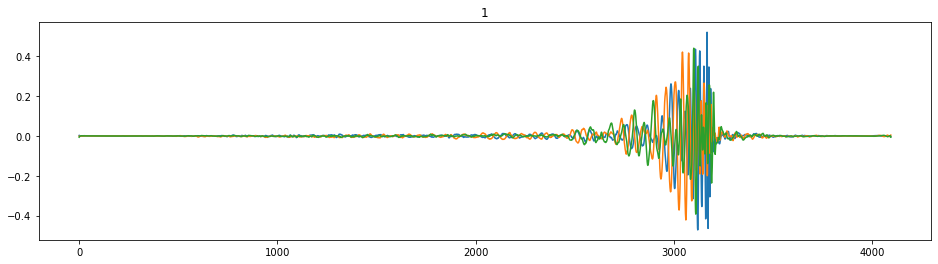

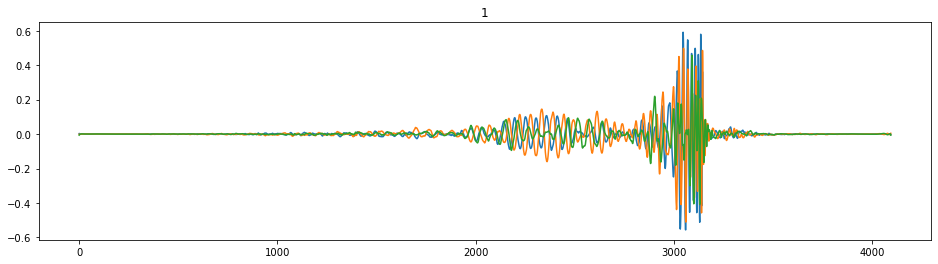

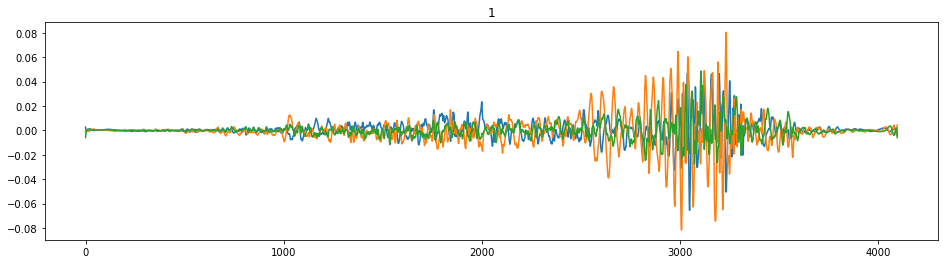

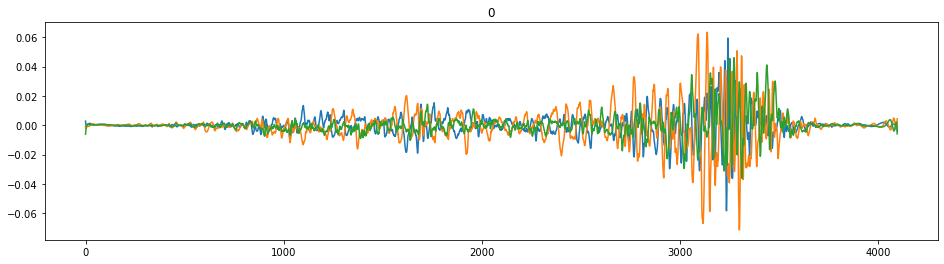

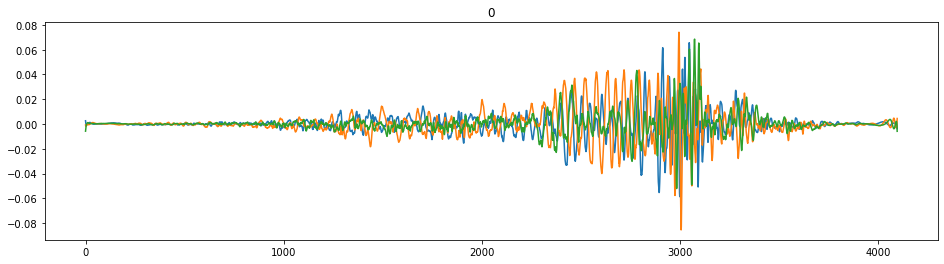

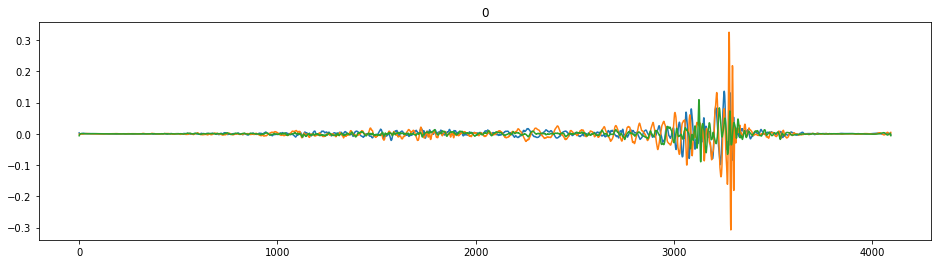

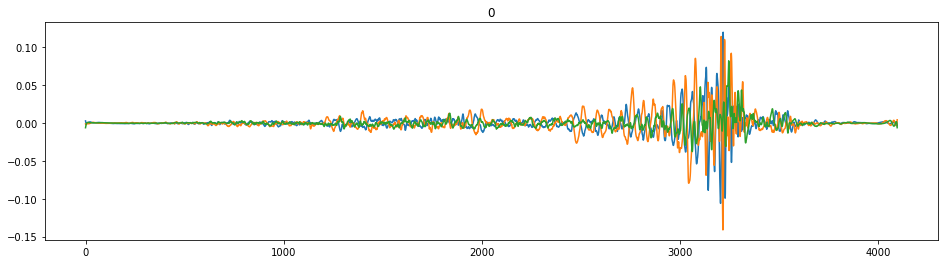

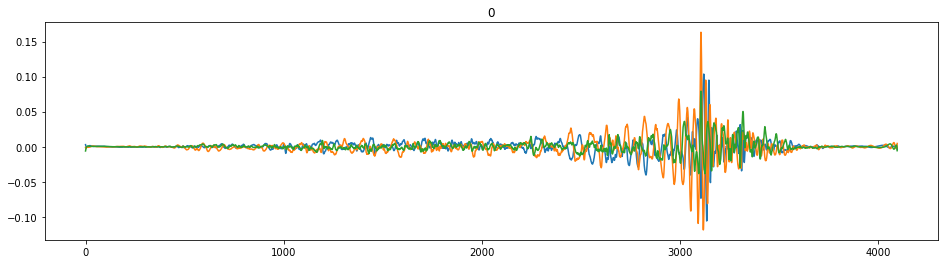

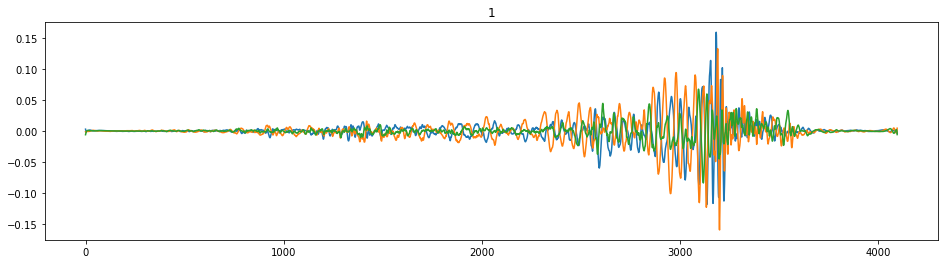

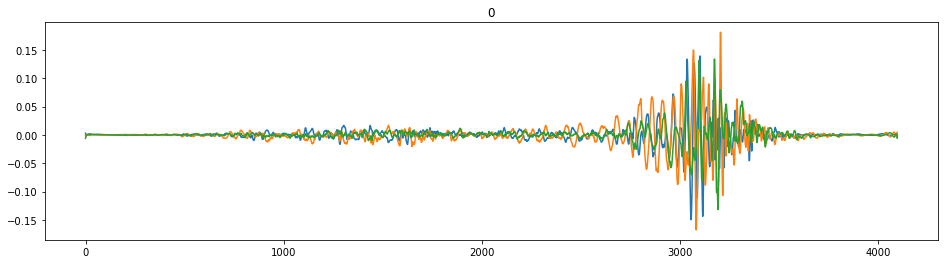

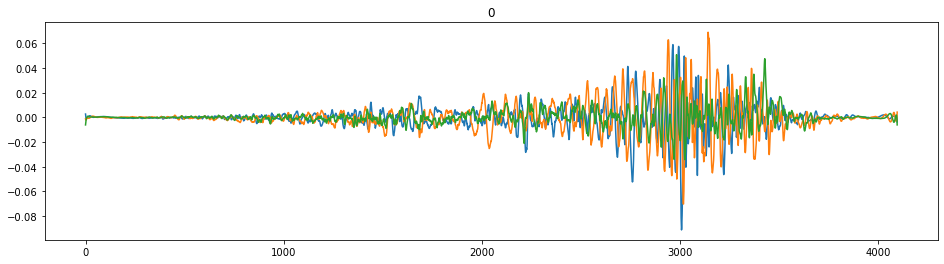

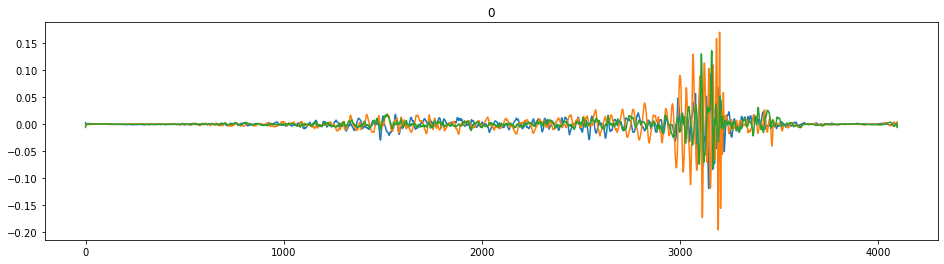

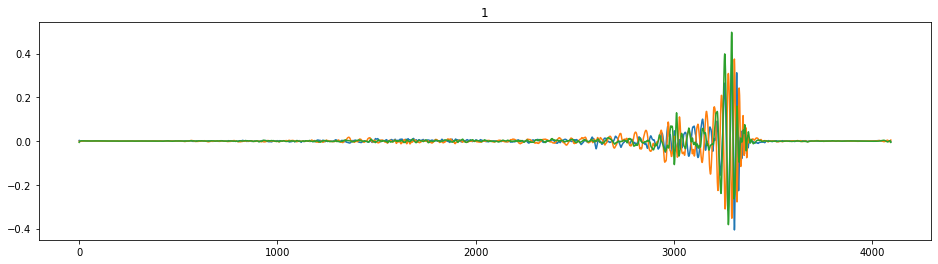

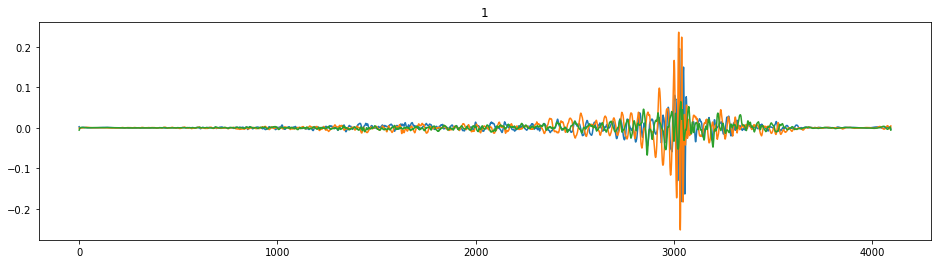

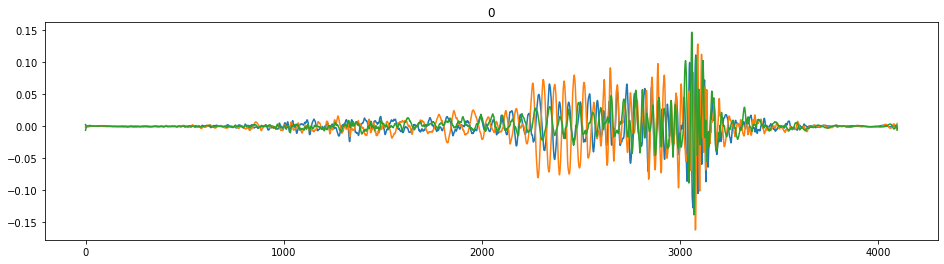

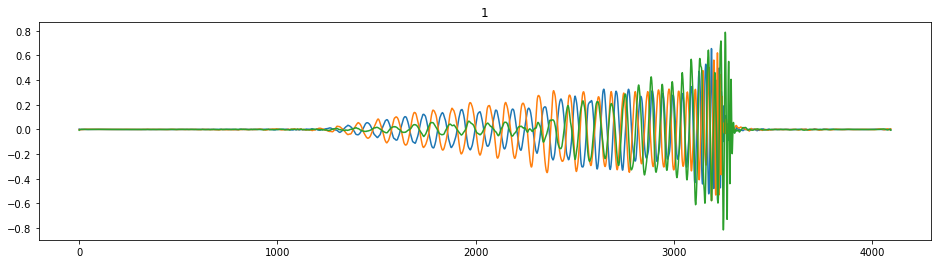

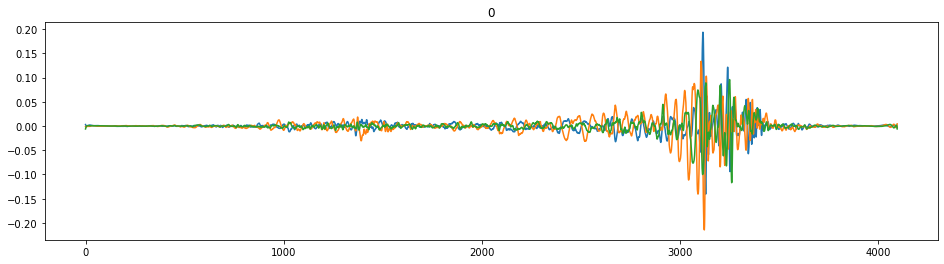

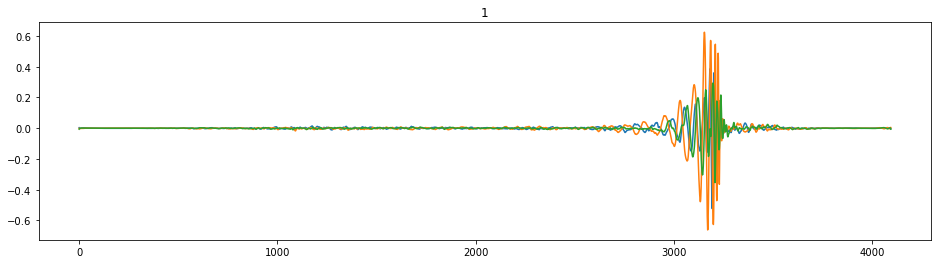

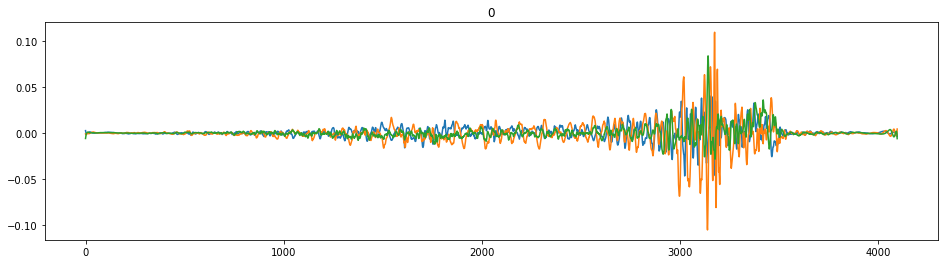

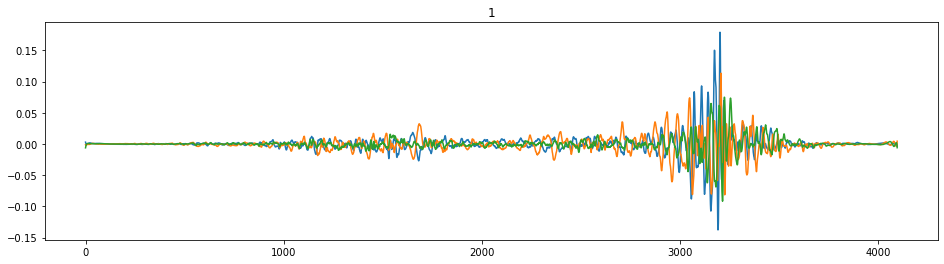

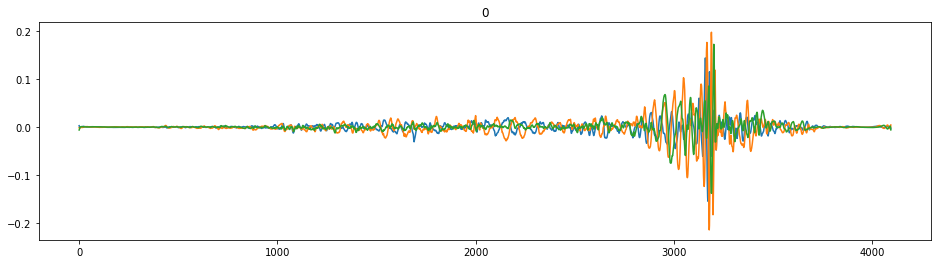

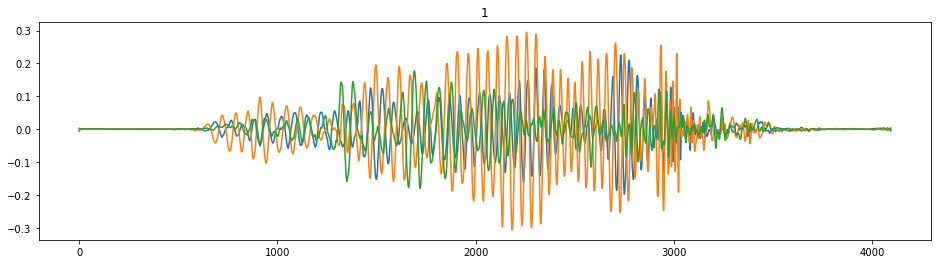

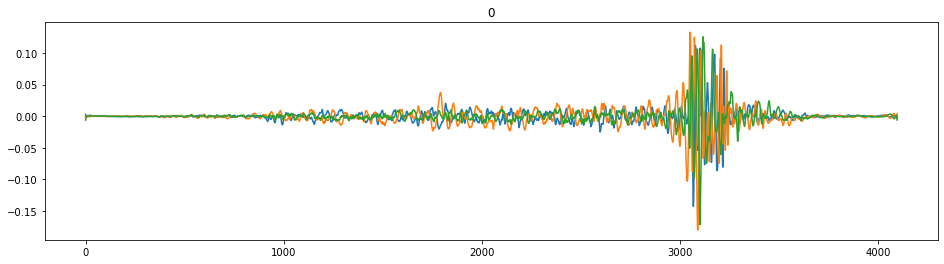

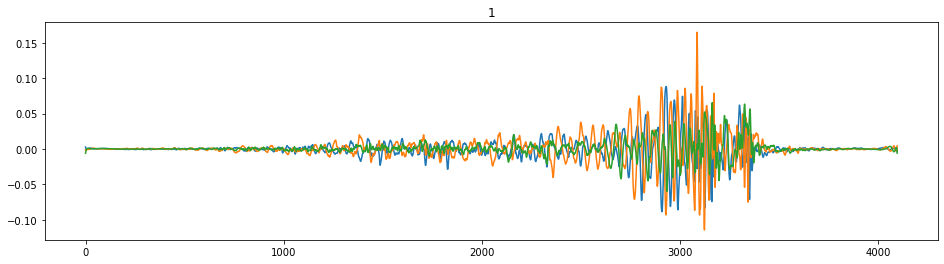

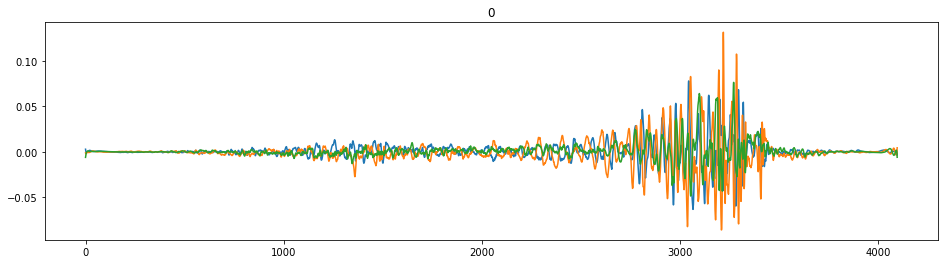

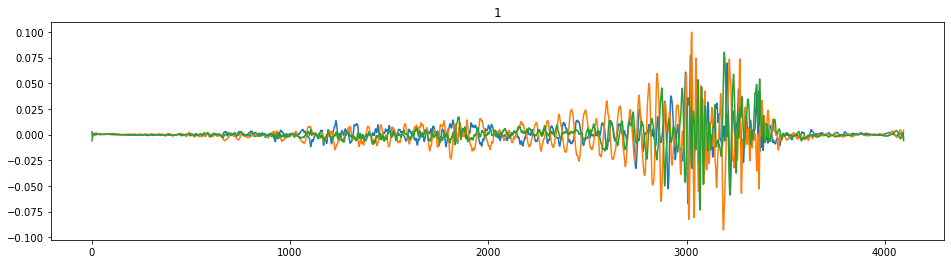

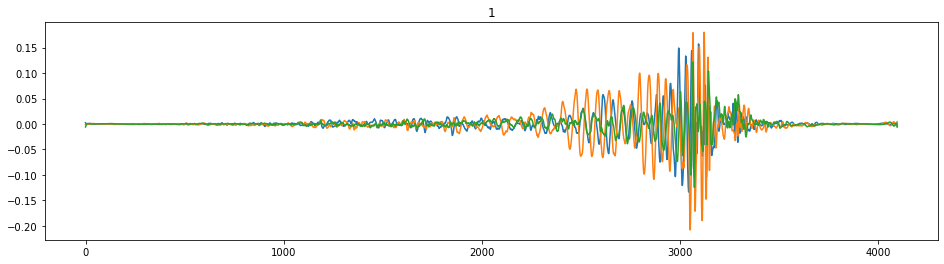

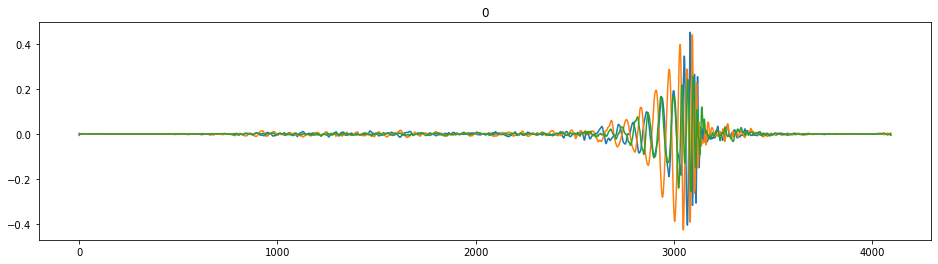

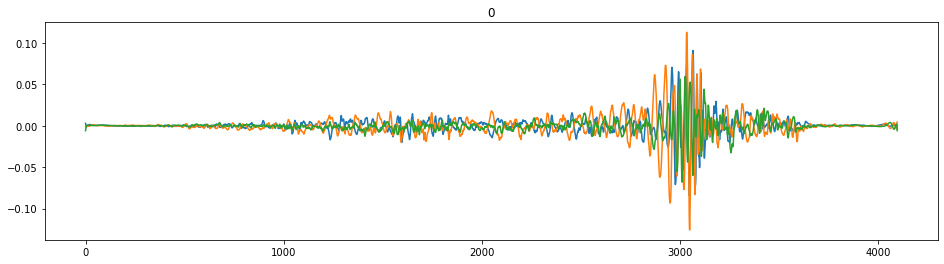

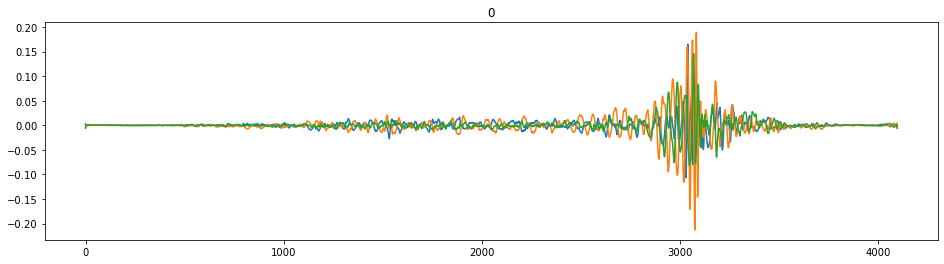

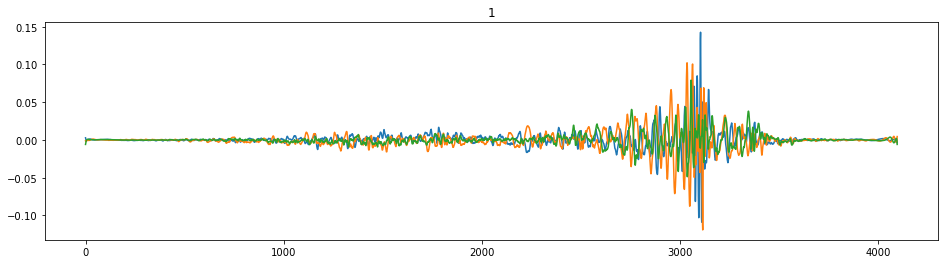

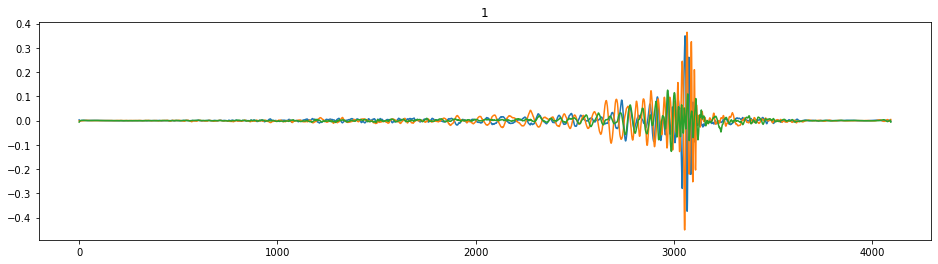

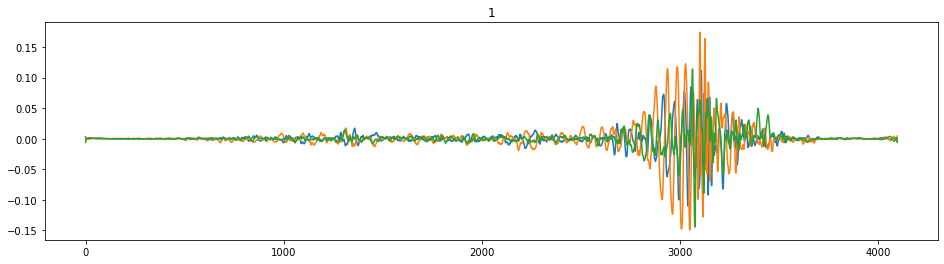

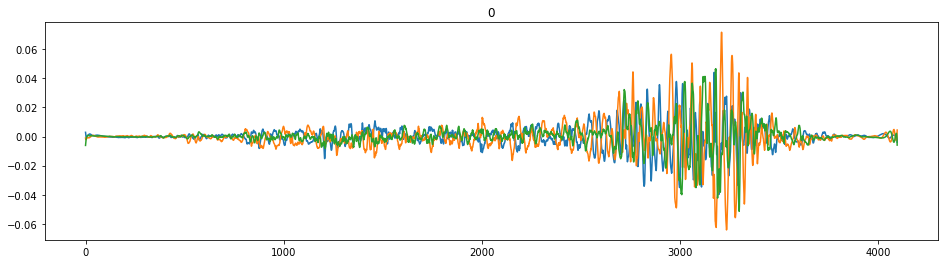

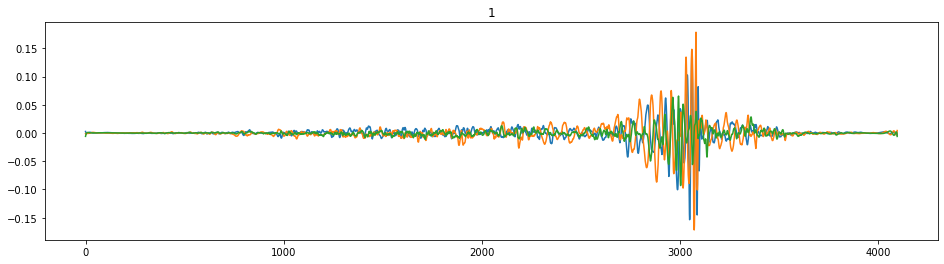

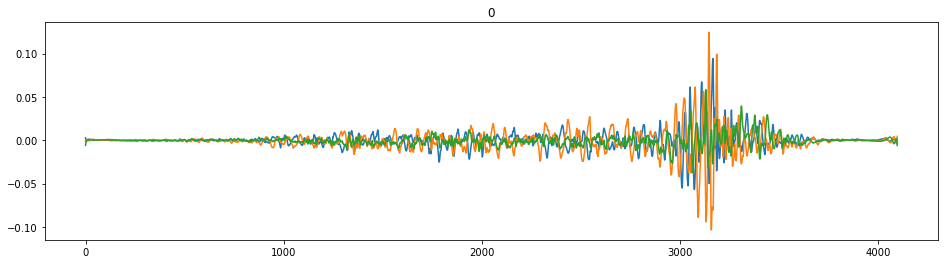

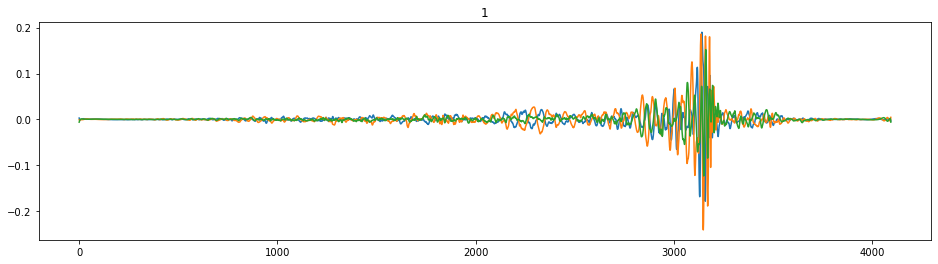

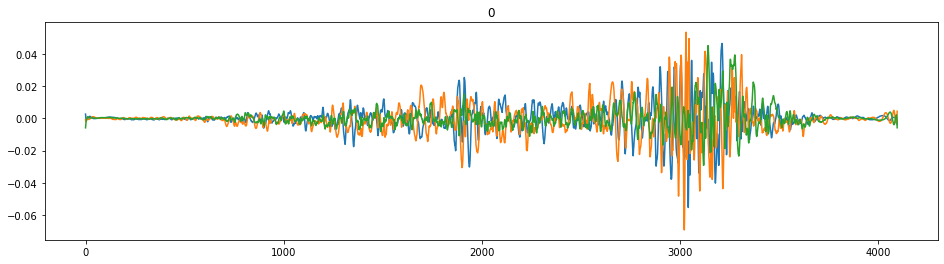

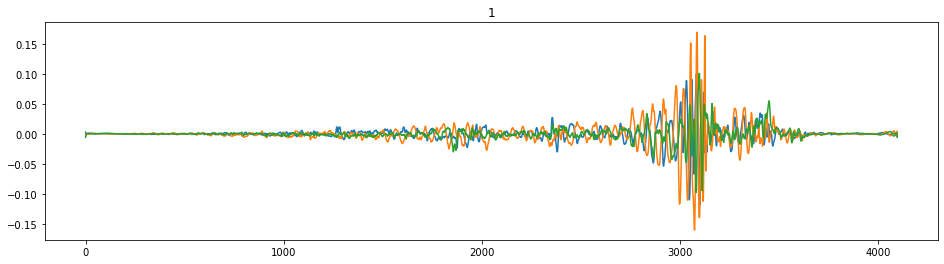

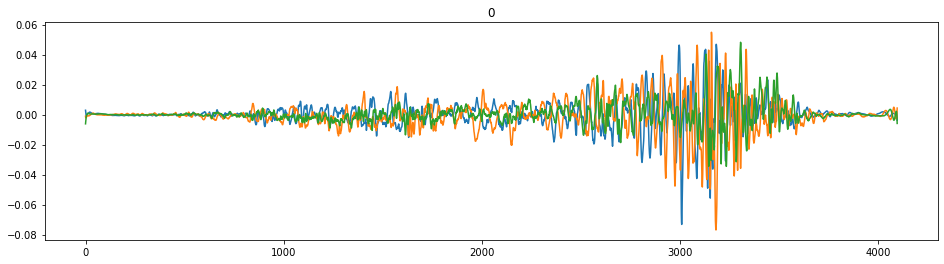

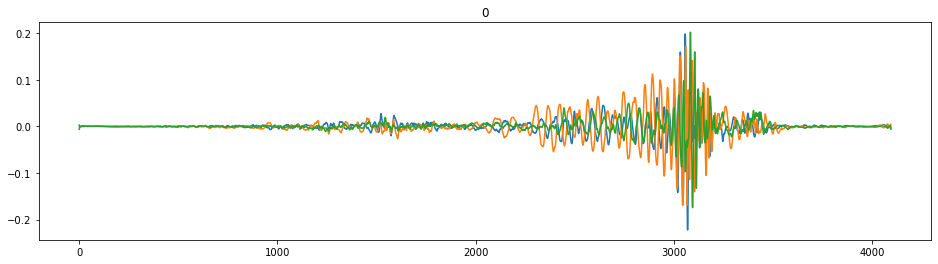

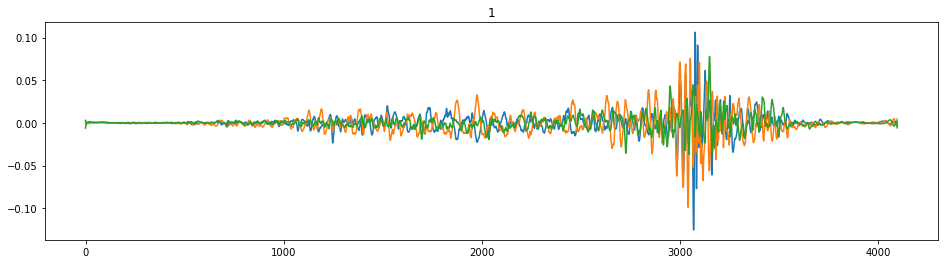

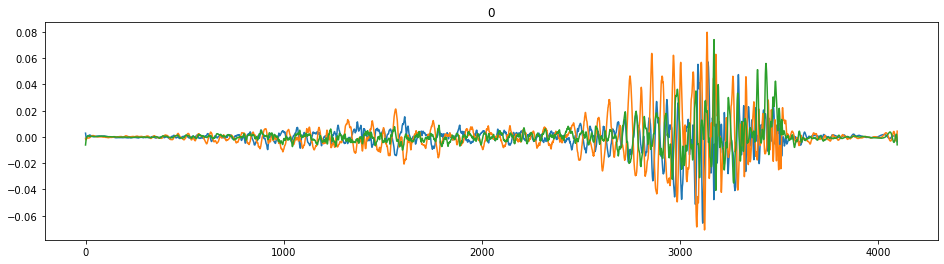

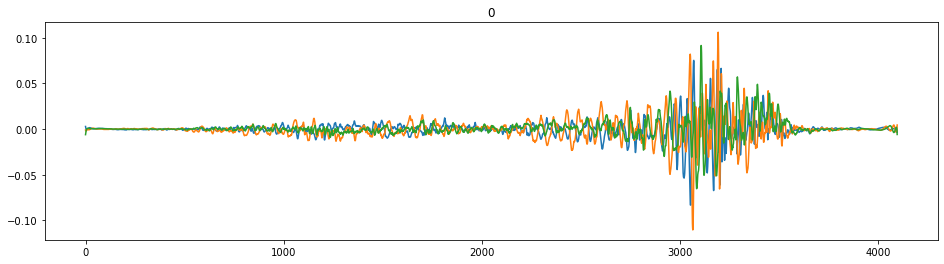

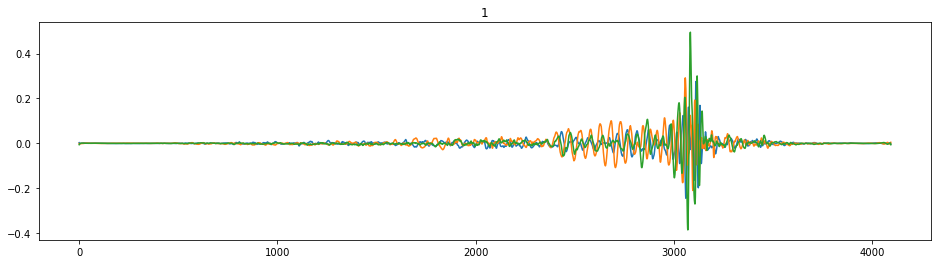

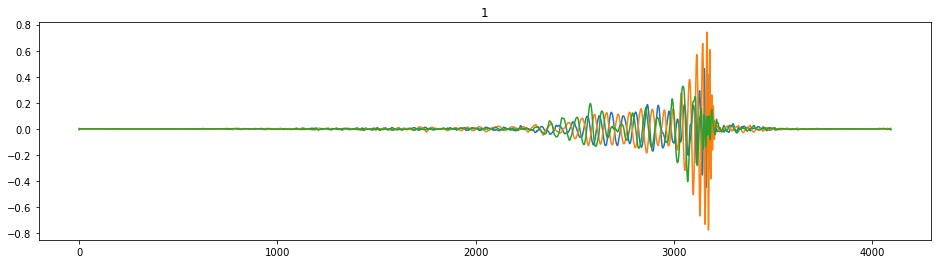

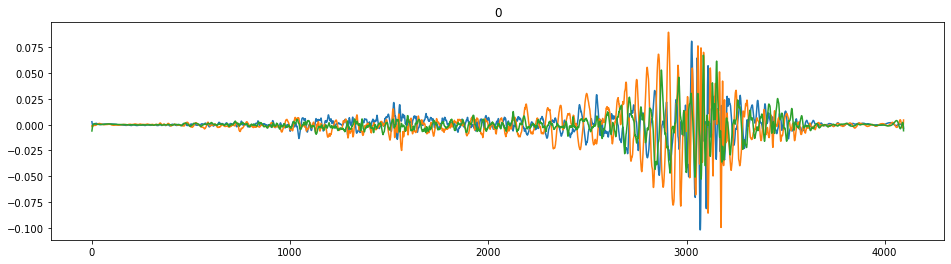

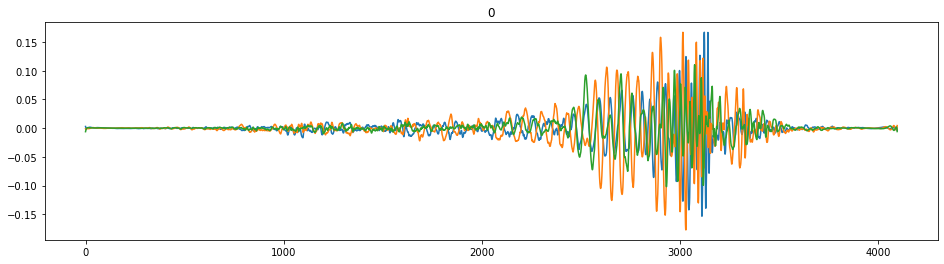

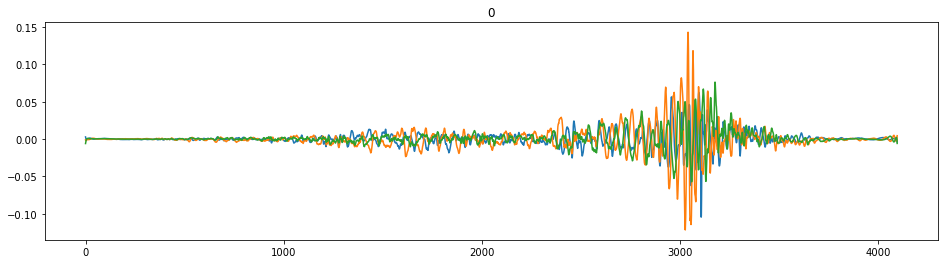

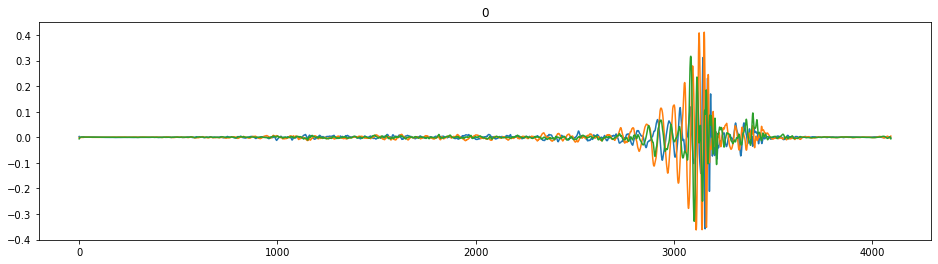

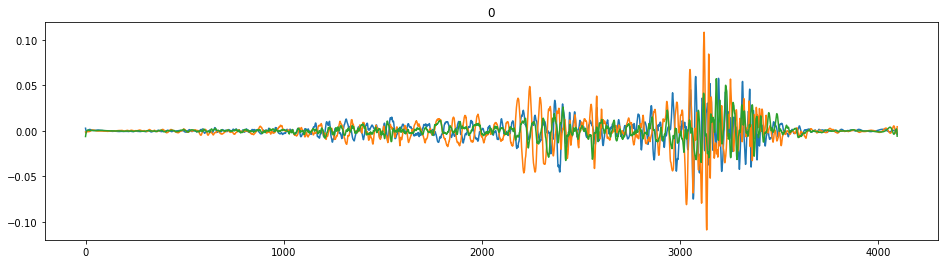

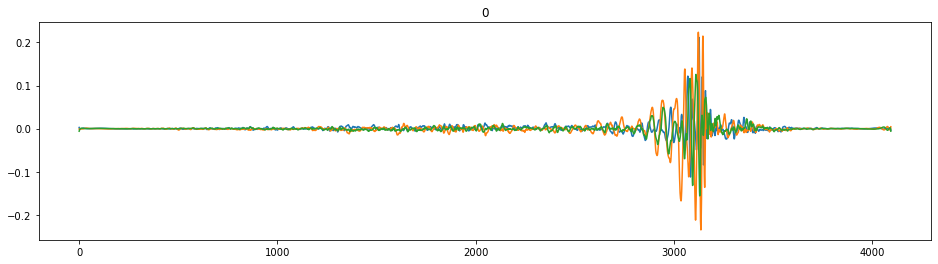

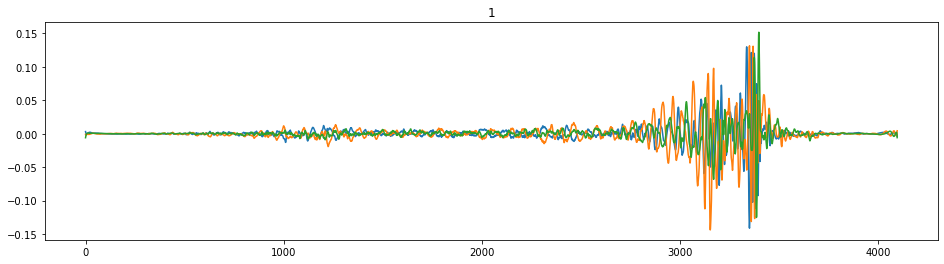

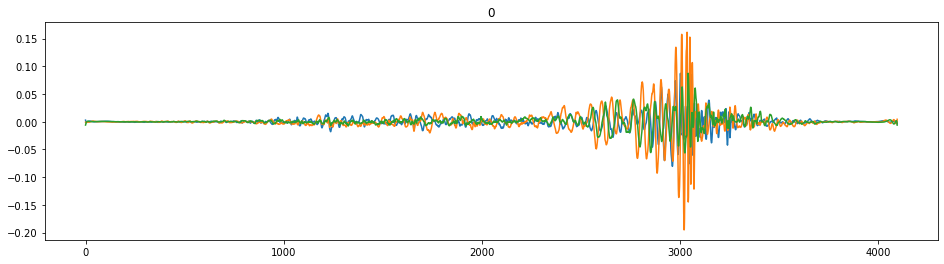

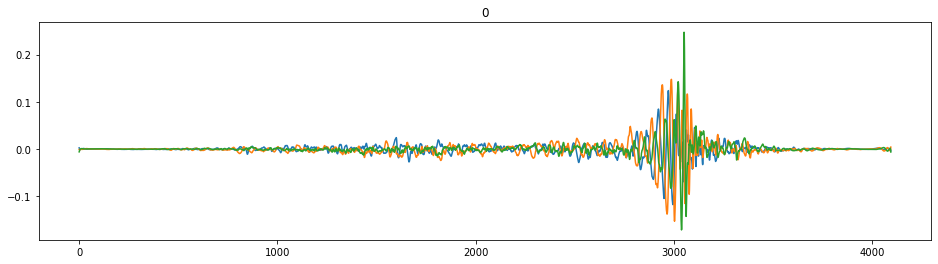

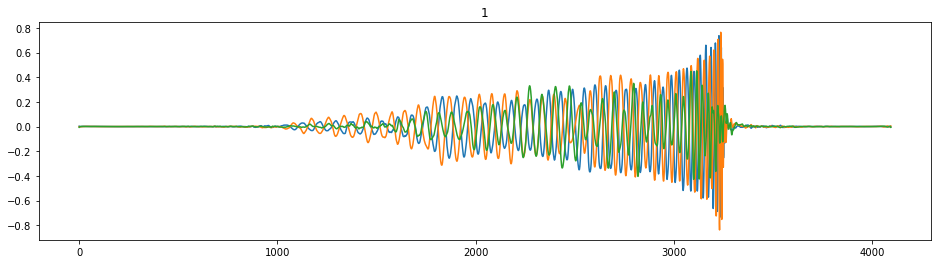

In [49]:
predictions = model.predict(vec[0])
# print(abs(predictions[vec[1]==1]).mean(),abs(predictions[vec[1]==0]).mean())
for i in range(64):
    plt.figure(figsize=(16,4))
    plt.plot(predictions[i])
#     plt.plot(vec[0][i])
    plt.title(vec[1][i].numpy())

    plt.show()